## Tutorial about the "GMVAE" module

In the following we give a quick guide on how to use this module.
The full list of required packages is given in the "torch_env.txt" file.
Probably any conda environment that has the following setup would work:
```
Python3.9+, Pandas, scanpy, anndata, pytorch, torchvision,
torchaudio, scipy, scikit-learn, seaborn, pyro, toolz,typing,typing-extensions,
jupyterlab, plotly, dash, python-graphviz, scikit-image, umap-learn,louvain,
datetime

```

## importing the required external libraries

In [74]:
from dash import Dash, html, dcc
from importlib import reload
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from toolz import partial, curry, pipe
from torch.nn.functional import one_hot
from torchvision import datasets, transforms, models
from torchvision.utils import save_image, make_grid
import anndata as ad
import functools
import itertools
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import operator
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import scanpy as sc
import seaborn as sns
import sys
import time
import toolz
import torch
import torch.utils.data
import torchvision.utils as vutils
import umap
from torch.nn import functional as F
from datetime import datetime

In [82]:
from sklearn.decomposition import PCA

## importing the gmvae modules

In [4]:
import gmvae.utils as ut
import gmvae.models as mmodels
import gmvae.training as training

True


## Setting some configuration (optiontal)

In [5]:
sc.settings.set_figure_params(
    dpi=200,
    facecolor="white",
)
#pio.renderers.default = "png"
sns.set_palette(sns.color_palette("pastel"),)
sns.set(rc={"figure.dpi":200, 'savefig.dpi':200})
matplotlib.rcParams['figure.dpi'] = 200
matplotlib.rcParams['savefig.dpi'] = 200
print(torch.cuda.is_available())

True


## Creating and plotting "blobs" toy dataset

We create a toy dataset to demonstrate how it is done and how to work with data.
the `ut.blobs` function returns an anndata (annotated data) type of object which is nice to work with and pretty much if you
want to work with RNASeq data in python you need to know how to use scanpy (which wraps around anndata).

The data is meant to symulate conditional mixture dataset, meaning there are $ny$ many primary classes (blobs)
but each class comes in $nc$ many conditions (e.g. before/after treatment).
The condition effect is meant to be smaller than the class difference and if for some reason blobs fails to do that than 
repeat the process or fix the code ;)

In [11]:
adata = ut.blobs(ns=350, nc=2, ny=5, effect=1.2, nx=16)
adata.obs["cond_m"] = 350*5*["p"] + 350*5*["x"]
adata.obs["color"] = [int(x) for x in adata.obs["label"]]

In [12]:
adata.obs

,label,cond,x1,x2,x3,cond_m,color
0,0,ctrl,1.087941,3.026053,4.795809,p,0
1,1,ctrl,10.642339,6.238698,7.769760,p,1
2,2,ctrl,6.175691,7.337260,9.136765,p,2
3,3,ctrl,0.476468,6.669182,6.880710,p,3
4,4,ctrl,4.899236,4.276367,8.785014,p,4
...,...,...,...,...,...,...,...
3495,0,trtmnt,2.273304,3.588098,5.954667,x,0
3496,1,trtmnt,10.885938,7.807871,8.866256,x,1
3497,2,trtmnt,7.890033,8.093517,9.424633,x,2
3498,3,trtmnt,1.823442,8.358316,8.293797,x,3


In [13]:
## doing pca
sc.pp.pca(adata,)
### Inserting the first 3 pcs into the obs dataframe so we can plot it
adata.obs[["pc1", "pc2", "pc3"]] = adata.obsm["X_pca"][:,:3]

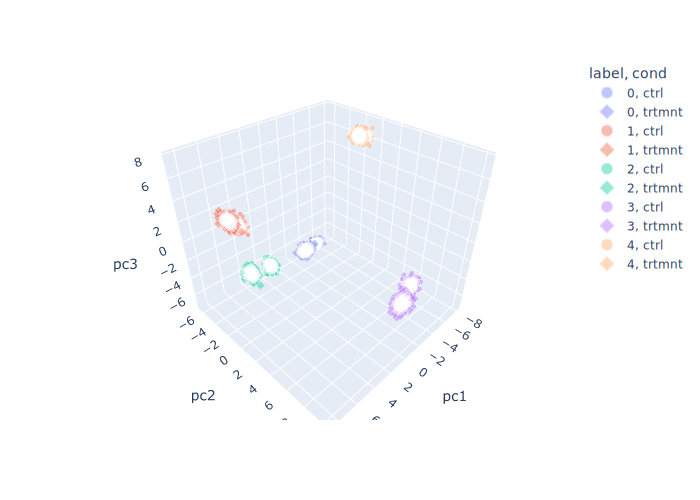

In [15]:
# plotting 3d scatter map
fig = px.scatter_3d(adata.obs,
                    x="pc1",y="pc2",z="pc3",
                    color="label",
                    symbol="cond",
                    size_max=8,
                    size=np.ones(len(adata.obs))*1,
                    opacity=0.4
                    )
fig.show(renderer="svg",)

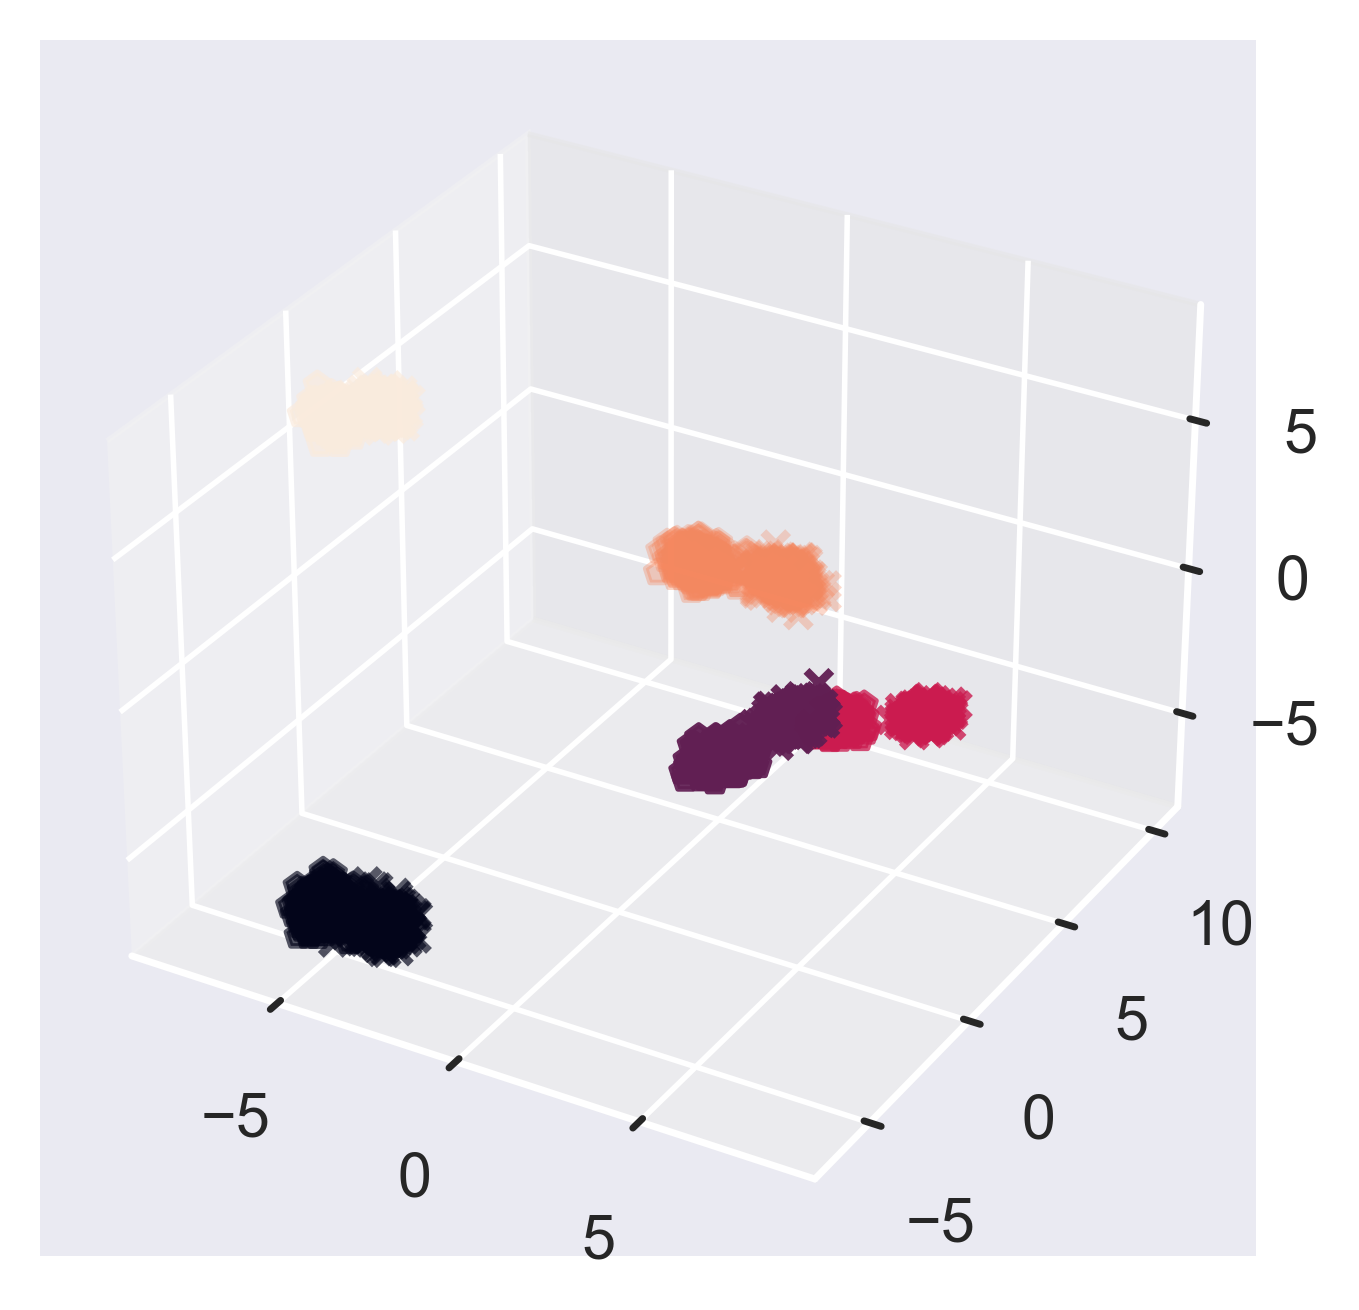

In [16]:
# alternative way to 3d plotting
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.scatter(
    data=adata.obs[adata.obs.cond == 'ctrl'],
    xs="pc1",
    ys="pc2",
    zs="pc3",
    c = "color",
    marker="p",
)
ax.scatter(
    data=adata.obs[adata.obs.cond == 'trtmnt'],
    xs="pc1",
    ys="pc2",
    zs="pc3",
    c = "color",
    marker="x",
)

/scratch/local/ipykernel_27374/997297329.py:2: UserWarning:

The palette list has more values (10) than needed (5), which may not be intended.



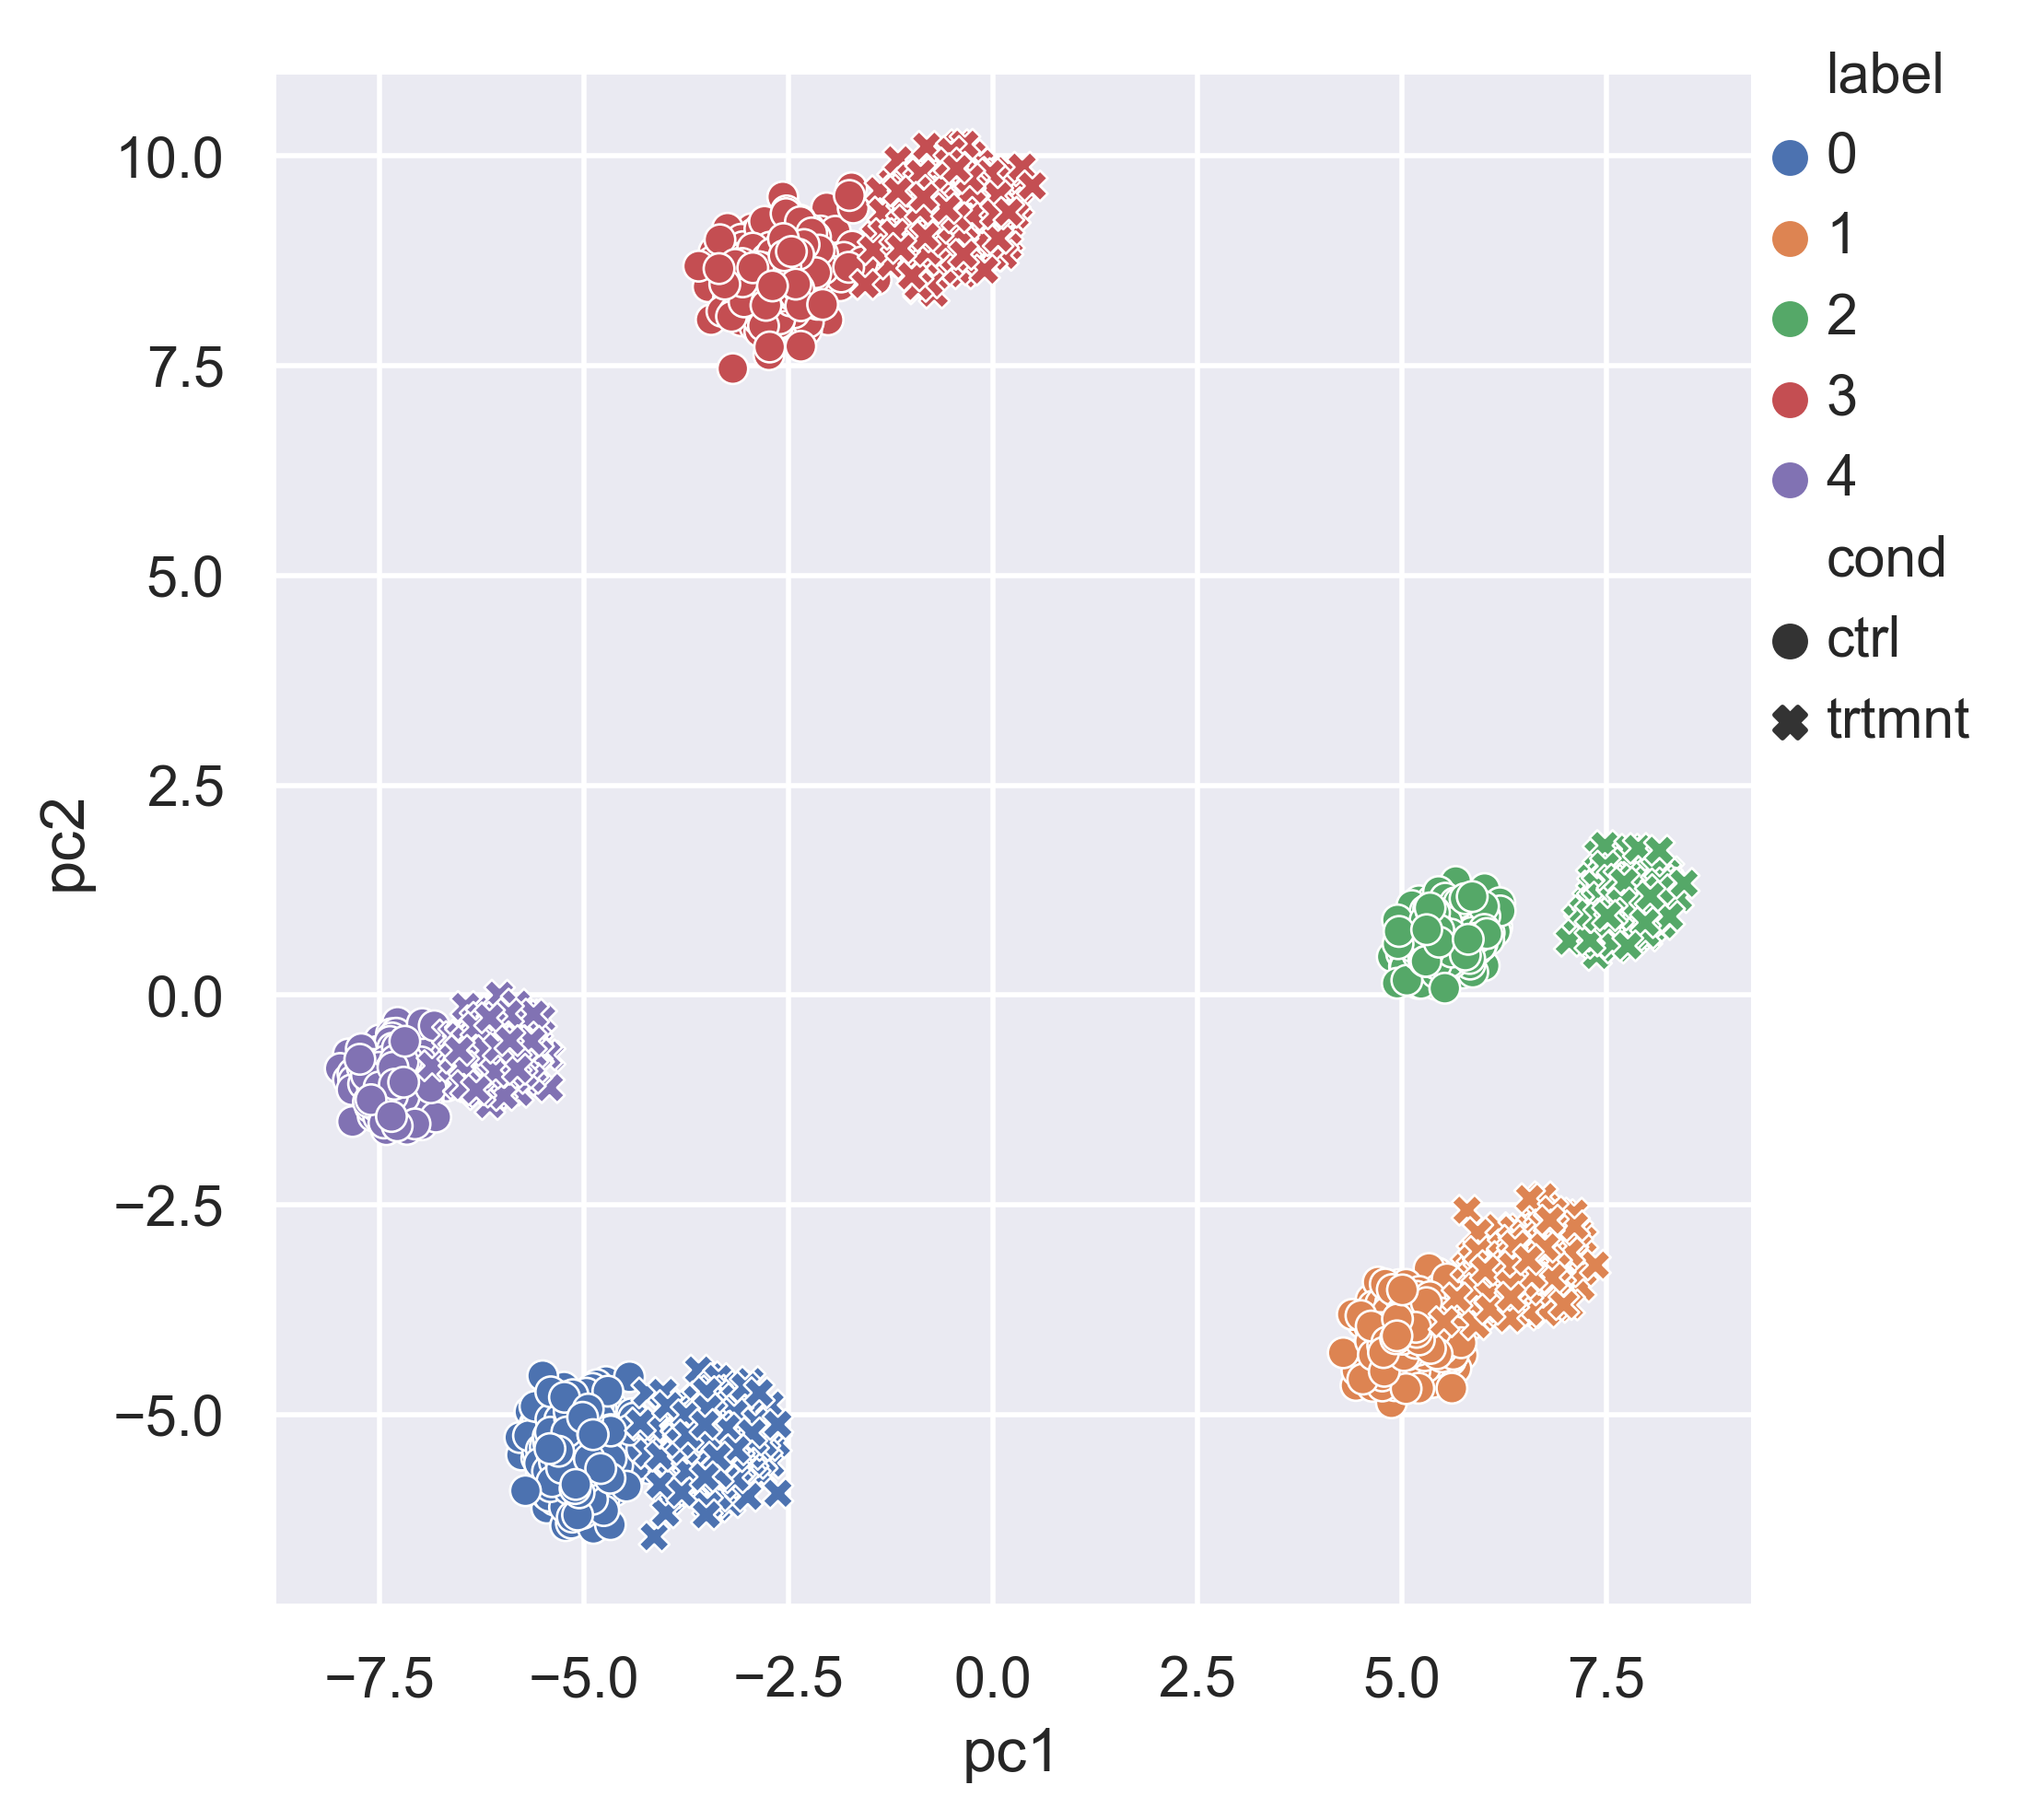

In [17]:
# Or if you're not into showing off and just want a convenient nice looking 2d plot:
ax = sns.relplot(
        adata.obs,
        x="pc1",
        y="pc2",
        hue="label",
        kind="scatter",
        legend="brief",
        style="cond",
        palette=sns.color_palette(),
        )
sns.move_legend(ax, "upper right",)

## preparing data and dataloader for training

In [21]:
labels_str = [str(x) for x in adata.obs["label"]]
labels = F.one_hot(torch.tensor([int(x) for x in labels_str])).float()
conditions_str = [str(x) for x in adata.obs["cond"]]
enc_conds = LabelEncoder()
conditions = F.one_hot(torch.tensor(enc_conds.fit_transform(conditions_str))).float()
data = torch.tensor(adata.X)

data_loader = torch.utils.data.DataLoader(
        dataset = ut.SynteticDataSet(
            [data,
                labels,
                conditions,
                ],),
            batch_size=2**11,
            shuffle=True,
            )

## setting up the model
we need a conditional gmvae for this data

In [24]:
model = mmodels.VAE_Dirichlet_GMM_TypeB1602zC2(
    nx=adata.n_vars,
    nz=2,
    nw=2,
    nclasses=labels.shape[1],
    nc1=conditions.shape[1],
    concentration=1.0e0,
    dropout=15e-2,
    bn=True,
    reclosstype="mse",
    #reclosstype="Gauss",
    restrict_w=True,
    restrict_z=True,
    positive_rec=True,
    #nh=2**11,
    #nhp=2**11,
    #nhq=2**11,
    numhidden=1,
    numhiddenp=1,
    numhiddenq=1,
    learned_prior=True,
    #learned_prior=False,
)
model.apply(ut.init_weights)
print()

## Unsupervised training

In [ ]:
training.basicTrainLoopCond(
    model,
    data_loader,
    data_loader,
    num_epochs=50,
    lrs = [
        1e-5,
        1e-4,
        1e-3,
        1e-3,
        1e-3,
        1e-3,
        1e-4,
        1e-5,
    ],
    test_accuracy=False,
    report_interval=0,
    wt=1e-4,
)

In [28]:
## testing accuracy
r,p,s = ut.estimateClusterImpurity(model, data, labels, "cuda", conditions)
print(p,r,s)
r = r[r>=0]
s = s[s>=0]
print("acc= \n", (r*s).sum().item() / s.sum().item(), r.mean().item())

[0. 2. 4. 3. 1.] [1. 1. 1. 1. 1.] [700. 700. 700. 700. 700.]
acc= 
 1.0 1.0


In [29]:
# insert latent encoding into the dataframe
output = model(data, cond1=conditions)
adata.obsm["mu_z"] = output["mu_z"].detach().numpy()
adata.obsm["z"] = output["z"].detach().numpy()
adata.obsm["mu_w"] = output["mu_w"].detach().numpy()
adata.obsm["w"] = output["w"].detach().numpy()
adata.obs["predict"] = output["q_y"].argmax(-1).detach().numpy().astype(str)
del output
adata.obs[["z1","z2",]] = adata.obsm["z"]
adata.obs[["mu_z1","mu_z2",]] = adata.obsm["mu_z"]
adata.obs[["w1","w2",]] = adata.obsm["w"]
adata.obs[["mu_w1","mu_w2",]] = adata.obsm["mu_w"]
adata.obs["predict"] = adata.obs["predict"]
adata.obs["predict_int"] = [int(x) for x in adata.obs["predict"]]

/scratch/local/ipykernel_27374/3932490200.py:2: UserWarning:

The palette list has more values (10) than needed (5), which may not be intended.



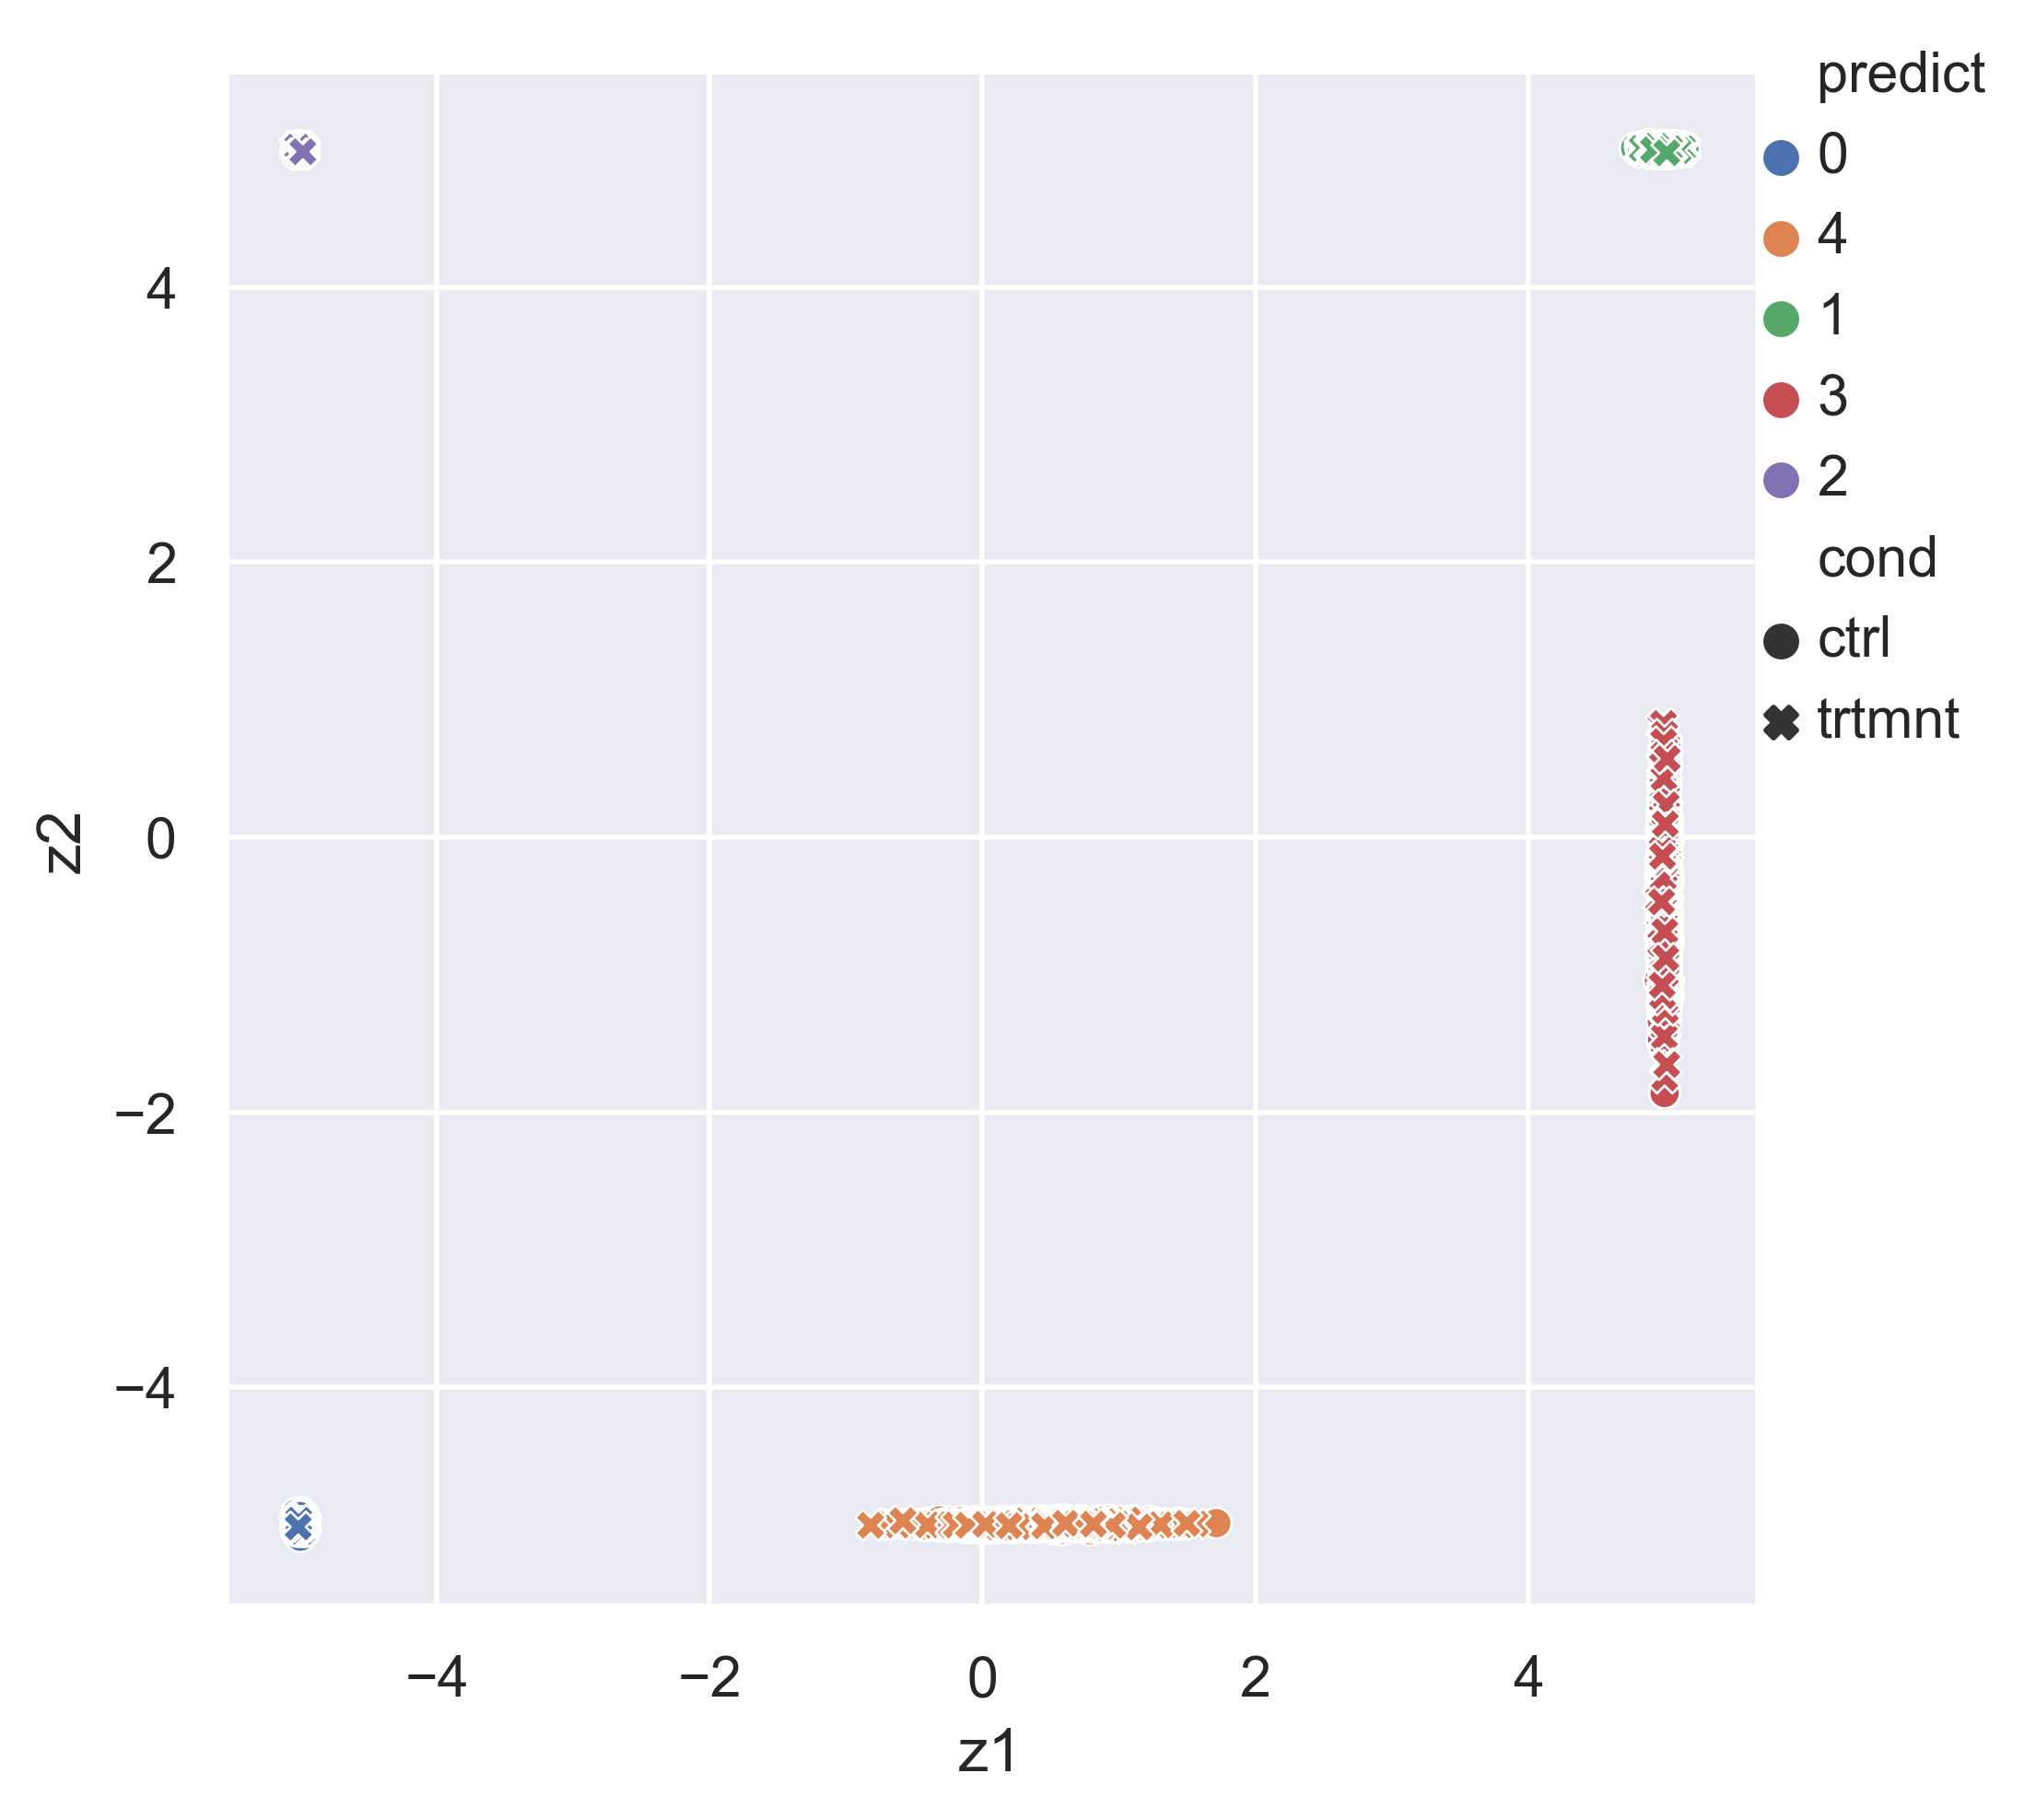

In [30]:
# and plot results
ax = sns.relplot(
        adata.obs,
        x="z1",
        y="z2",
        hue="predict",
        kind="scatter",
        legend="brief",
        style="cond",
        palette=sns.color_palette(),
        )
sns.move_legend(ax, "upper right",)

/scratch/local/ipykernel_27374/3307855646.py:1: UserWarning:

The palette list has more values (10) than needed (5), which may not be intended.



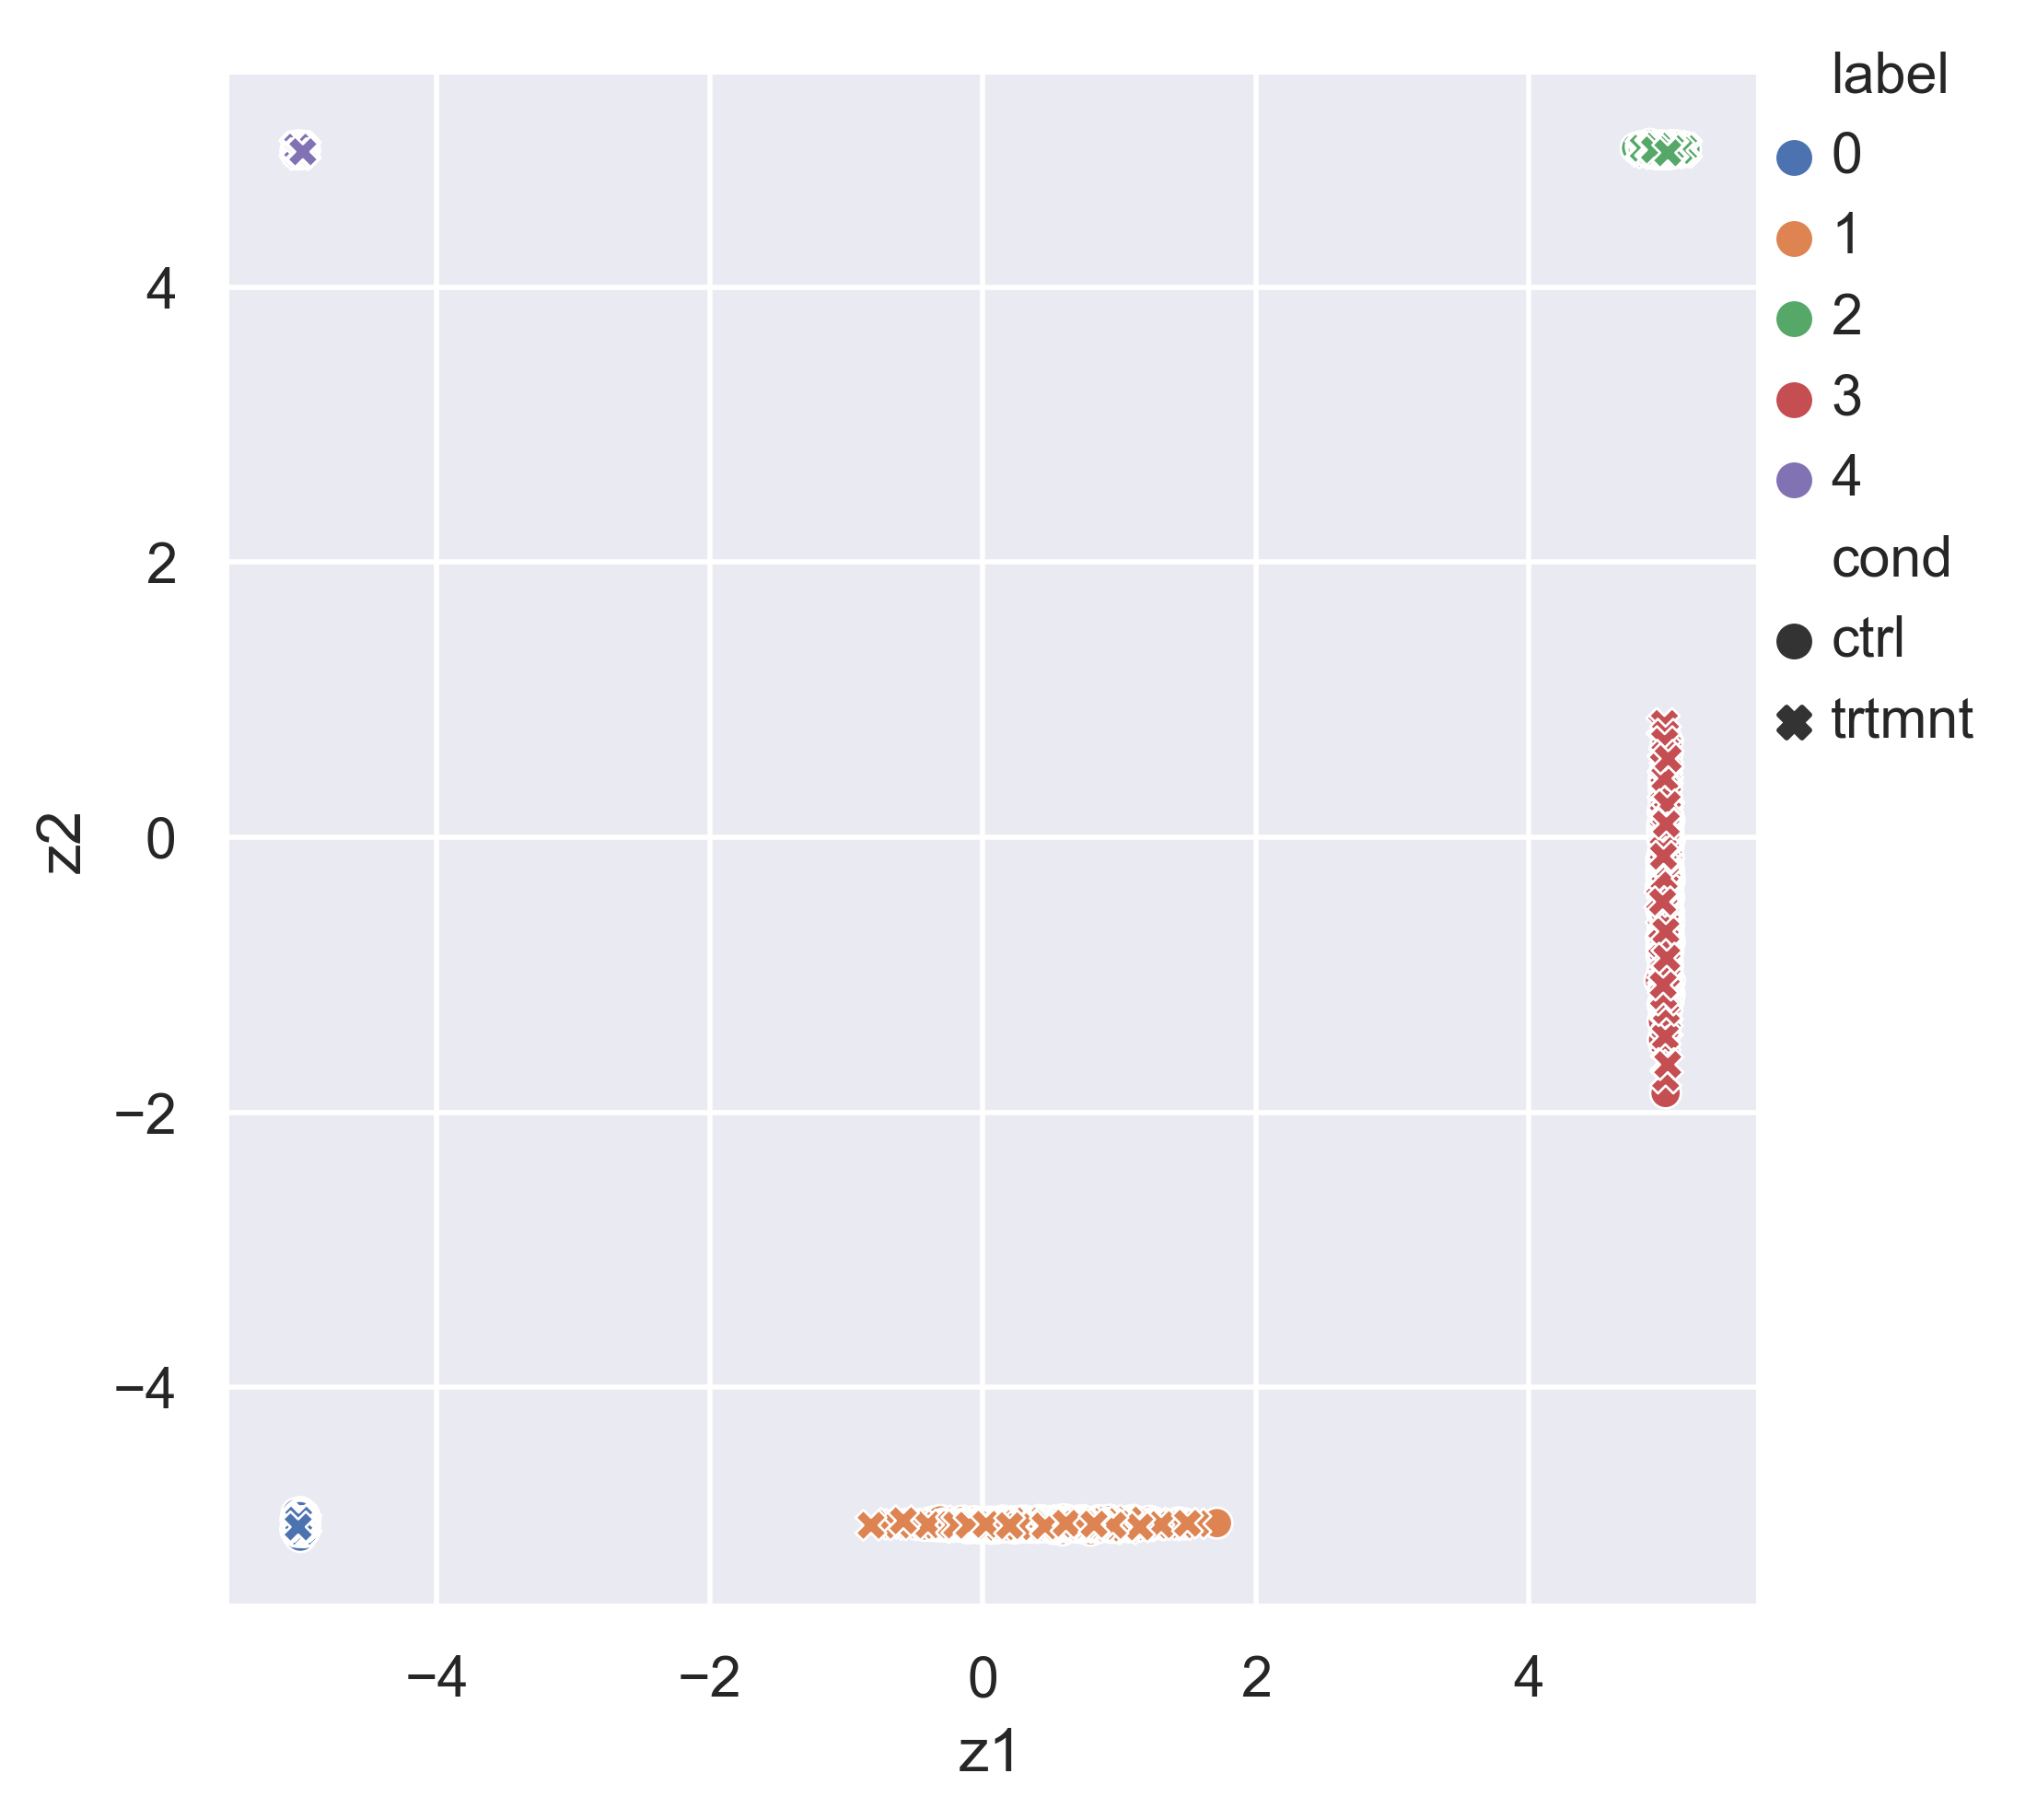

In [32]:
ax = sns.relplot(
        adata.obs,
        x="z1",
        y="z2",
        hue="label",
        kind="scatter",
        legend="brief",
        style="cond",
        palette=sns.color_palette(),
        )
sns.move_legend(ax, "upper right",)


/scratch/local/ipykernel_27374/1238589773.py:2: UserWarning:

The palette list has more values (10) than needed (5), which may not be intended.



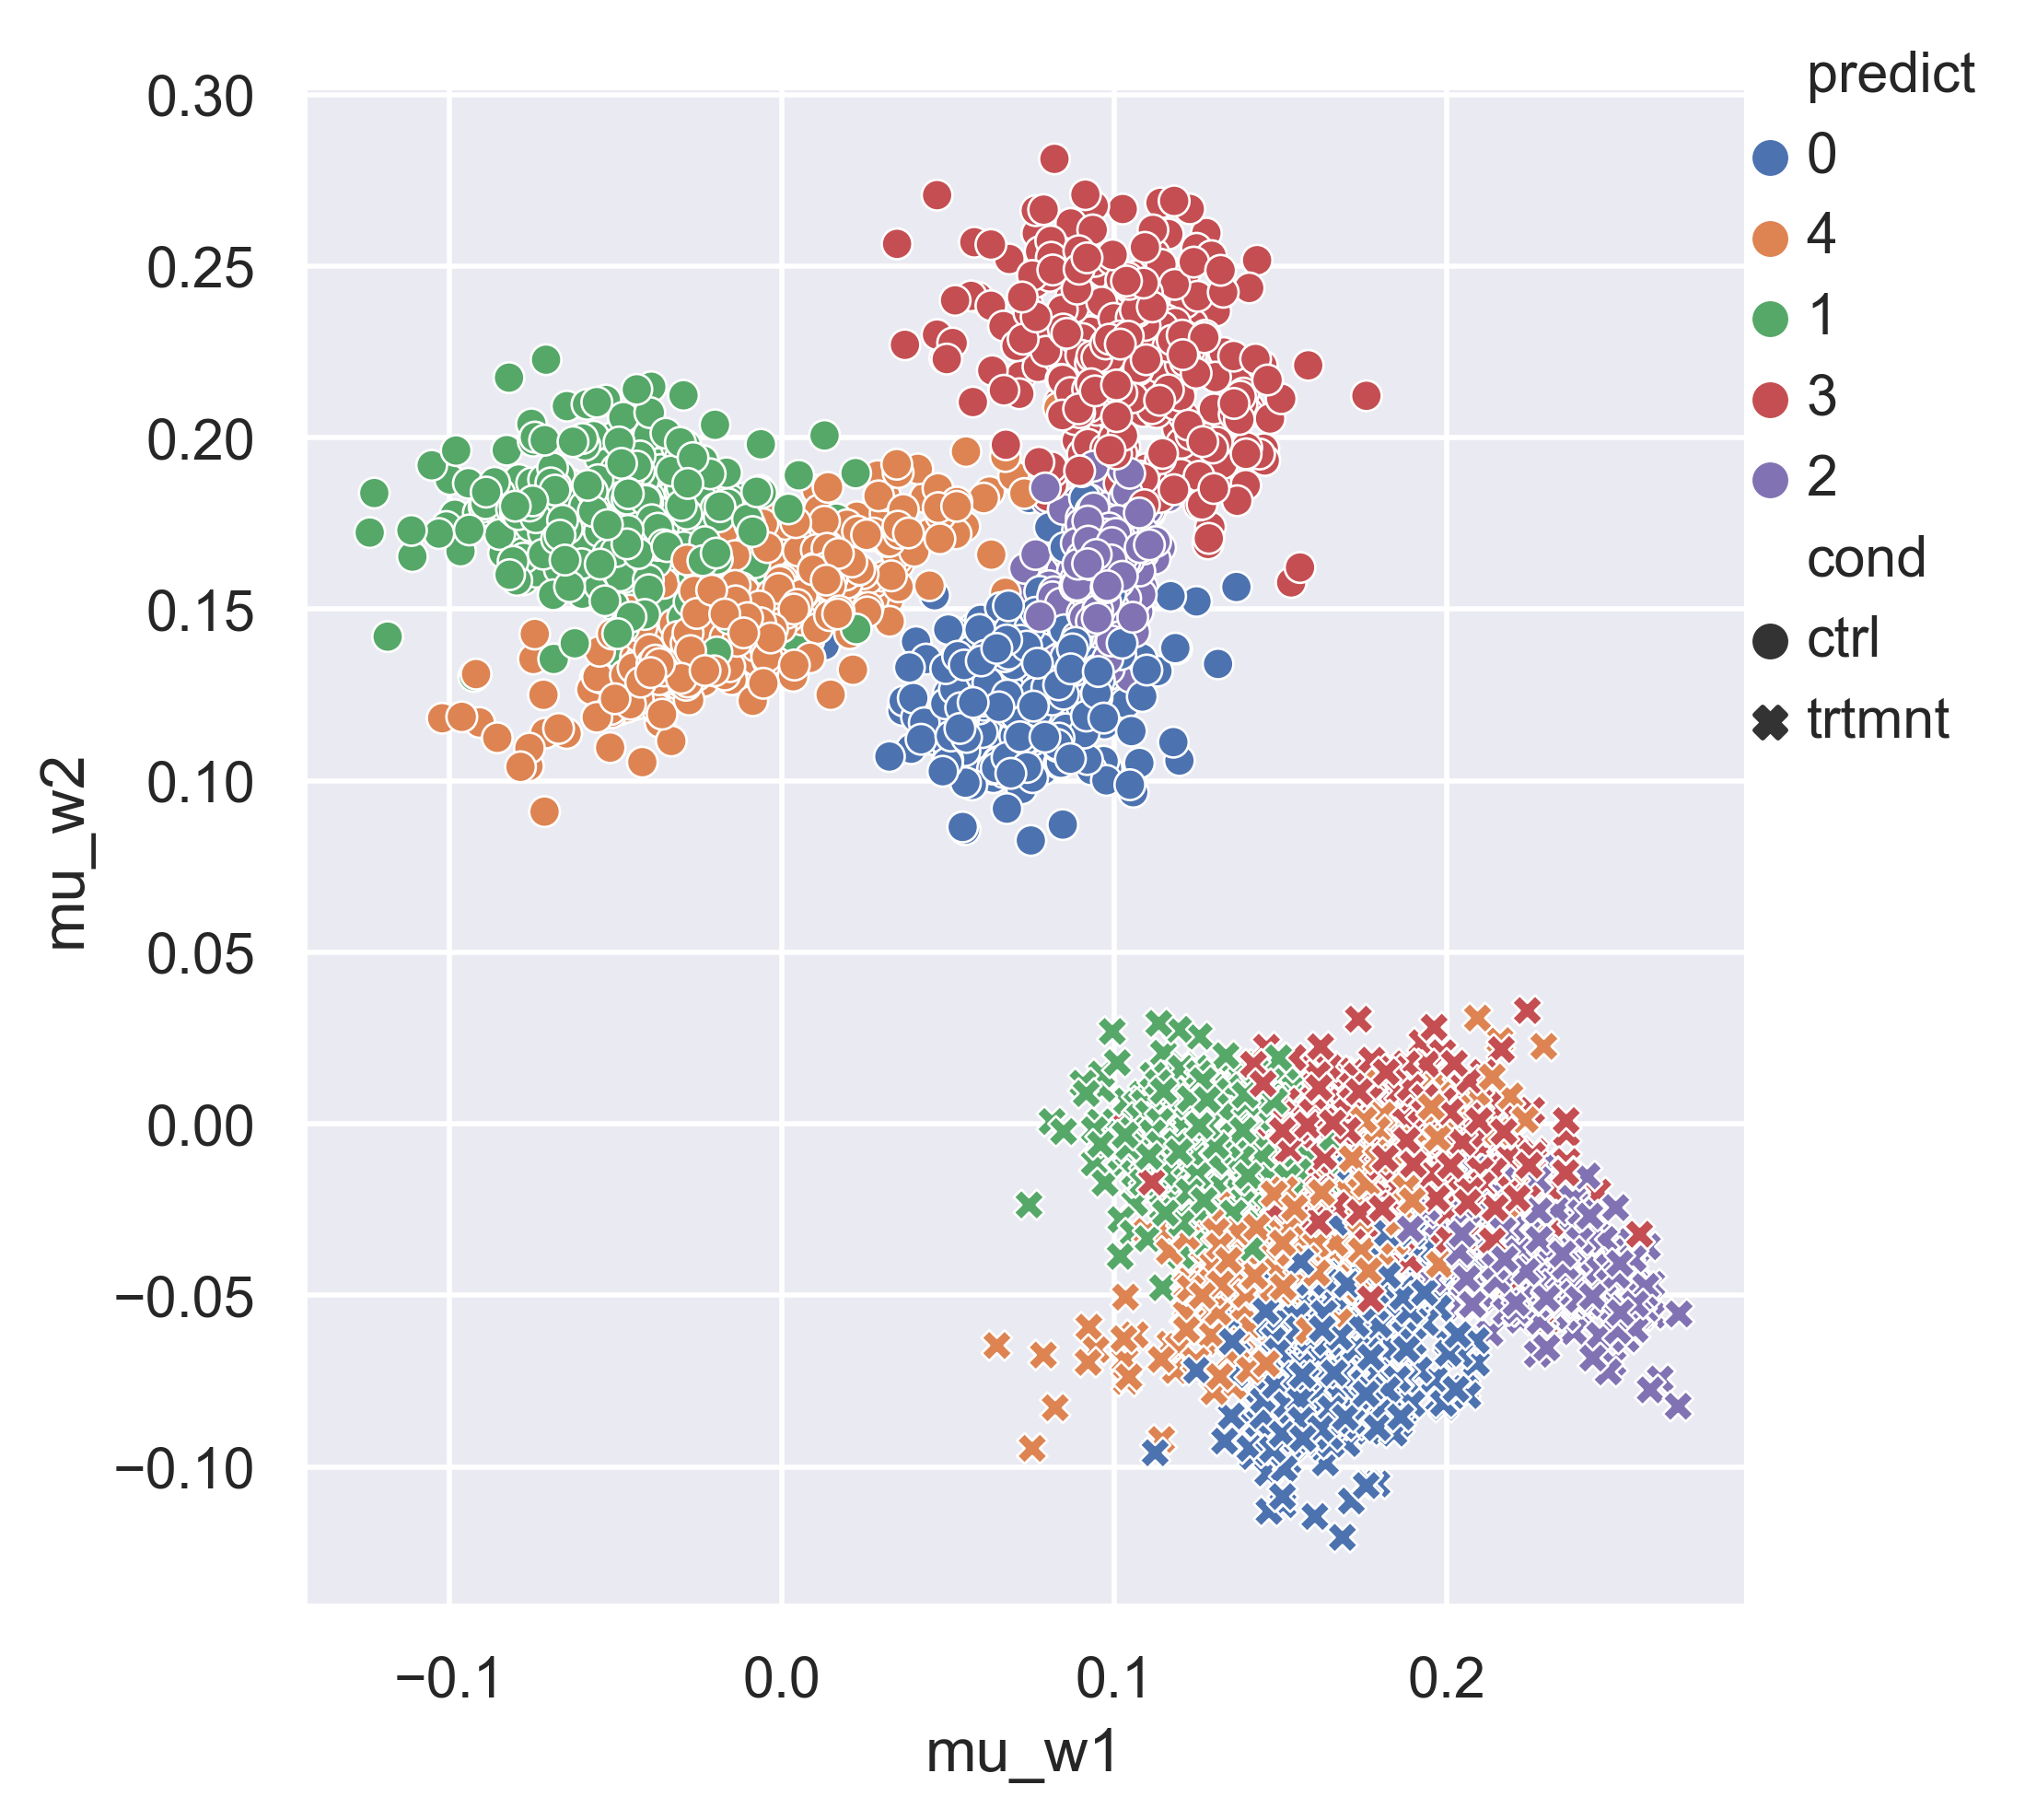

In [31]:
# and plot results
ax = sns.relplot(
        adata.obs,
        x="mu_w1",
        y="mu_w2",
        hue="predict",
        kind="scatter",
        legend="brief",
        style="cond",
        palette=sns.color_palette(),
        )
sns.move_legend(ax, "upper right",)

## Working with scRNASeq and similar data
You need to download your favorite dataset and import it with scanpy. Datasets are available in multiple formats and if you
are unfamiliar look in the scanpy documentation.
We're going to demonstrate loading data in ".h4ad" format (Zheng et al dataset)

In [50]:
adataz = sc.read_h5ad("./data/scgen/scGen_datasets/train_zheng.h5ad",)
adataz.obs
adataz.X = adataz.X.toarray()

/home/ykolb/mambaforge/envs/torch/lib/python3.9/site-packages/anndata/compat/__init__.py:232: FutureWarning:

Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.

/home/ykolb/mambaforge/envs/torch/lib/python3.9/site-packages/anndata/compat/__init__.py:232: FutureWarning:

Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.



In [51]:
adataz.obsm

AxisArrays with keys: X_pca, X_umap, X_tsne

/home/ykolb/mambaforge/envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



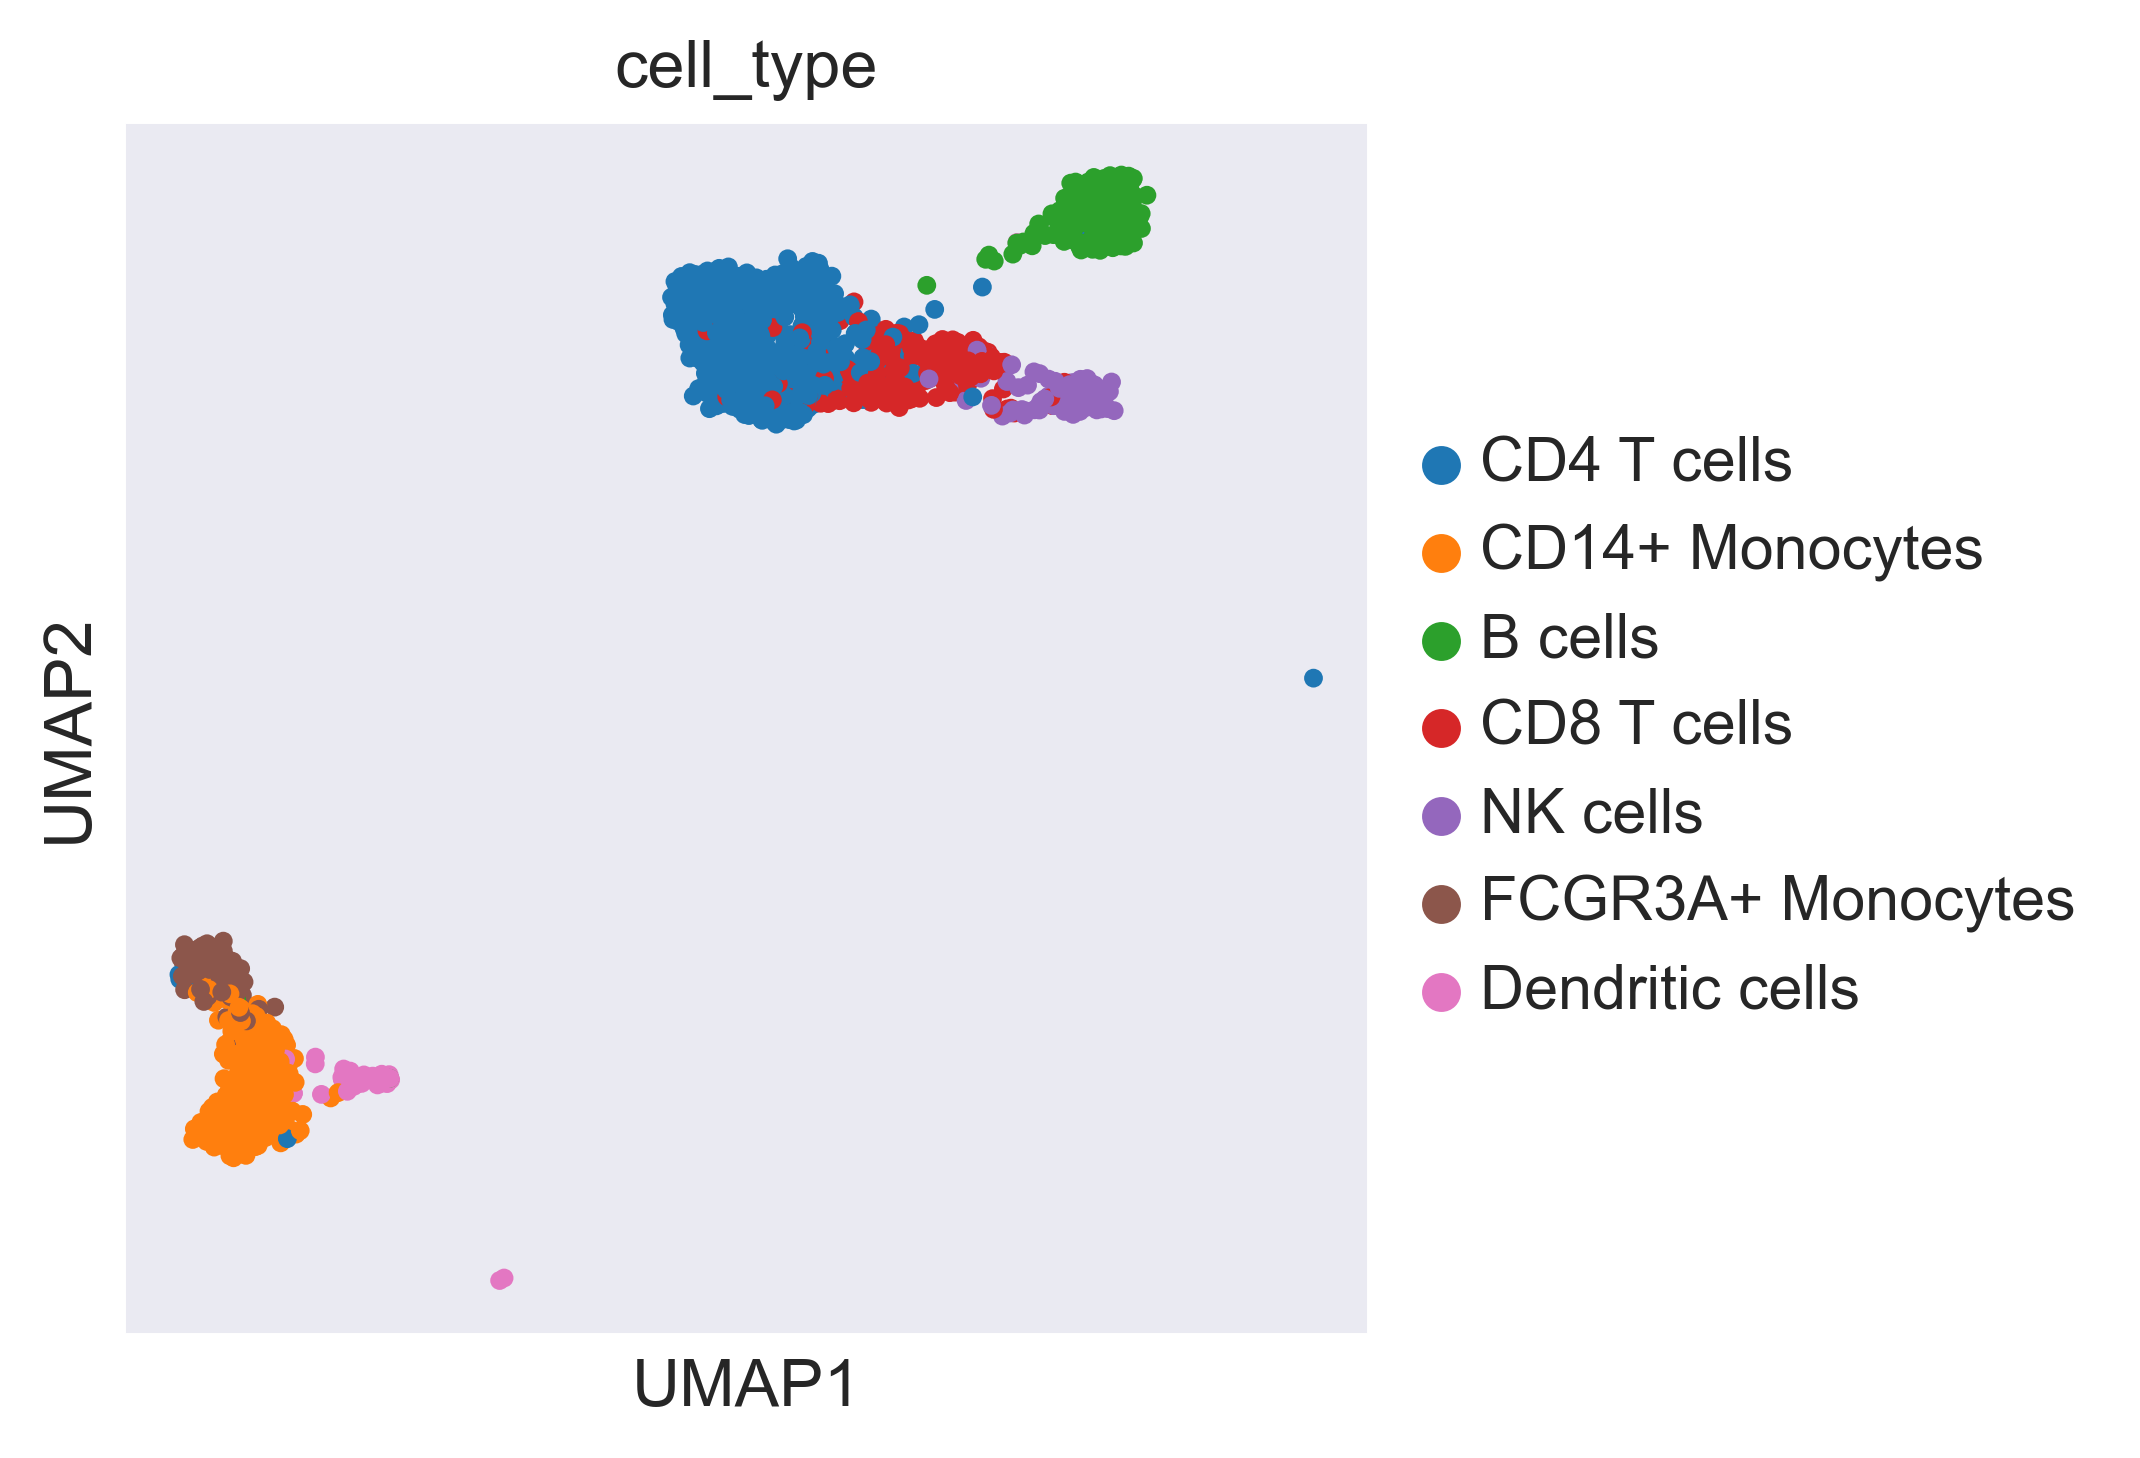

In [52]:
adataz.obs[["um1", "um2"]] = adataz.obsm["X_umap"]
sc.pl.umap(
    adataz,
    ncols=2,
    color=[
        "cell_type",
    ],
)

/home/ykolb/mambaforge/envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored

/home/ykolb/mambaforge/envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



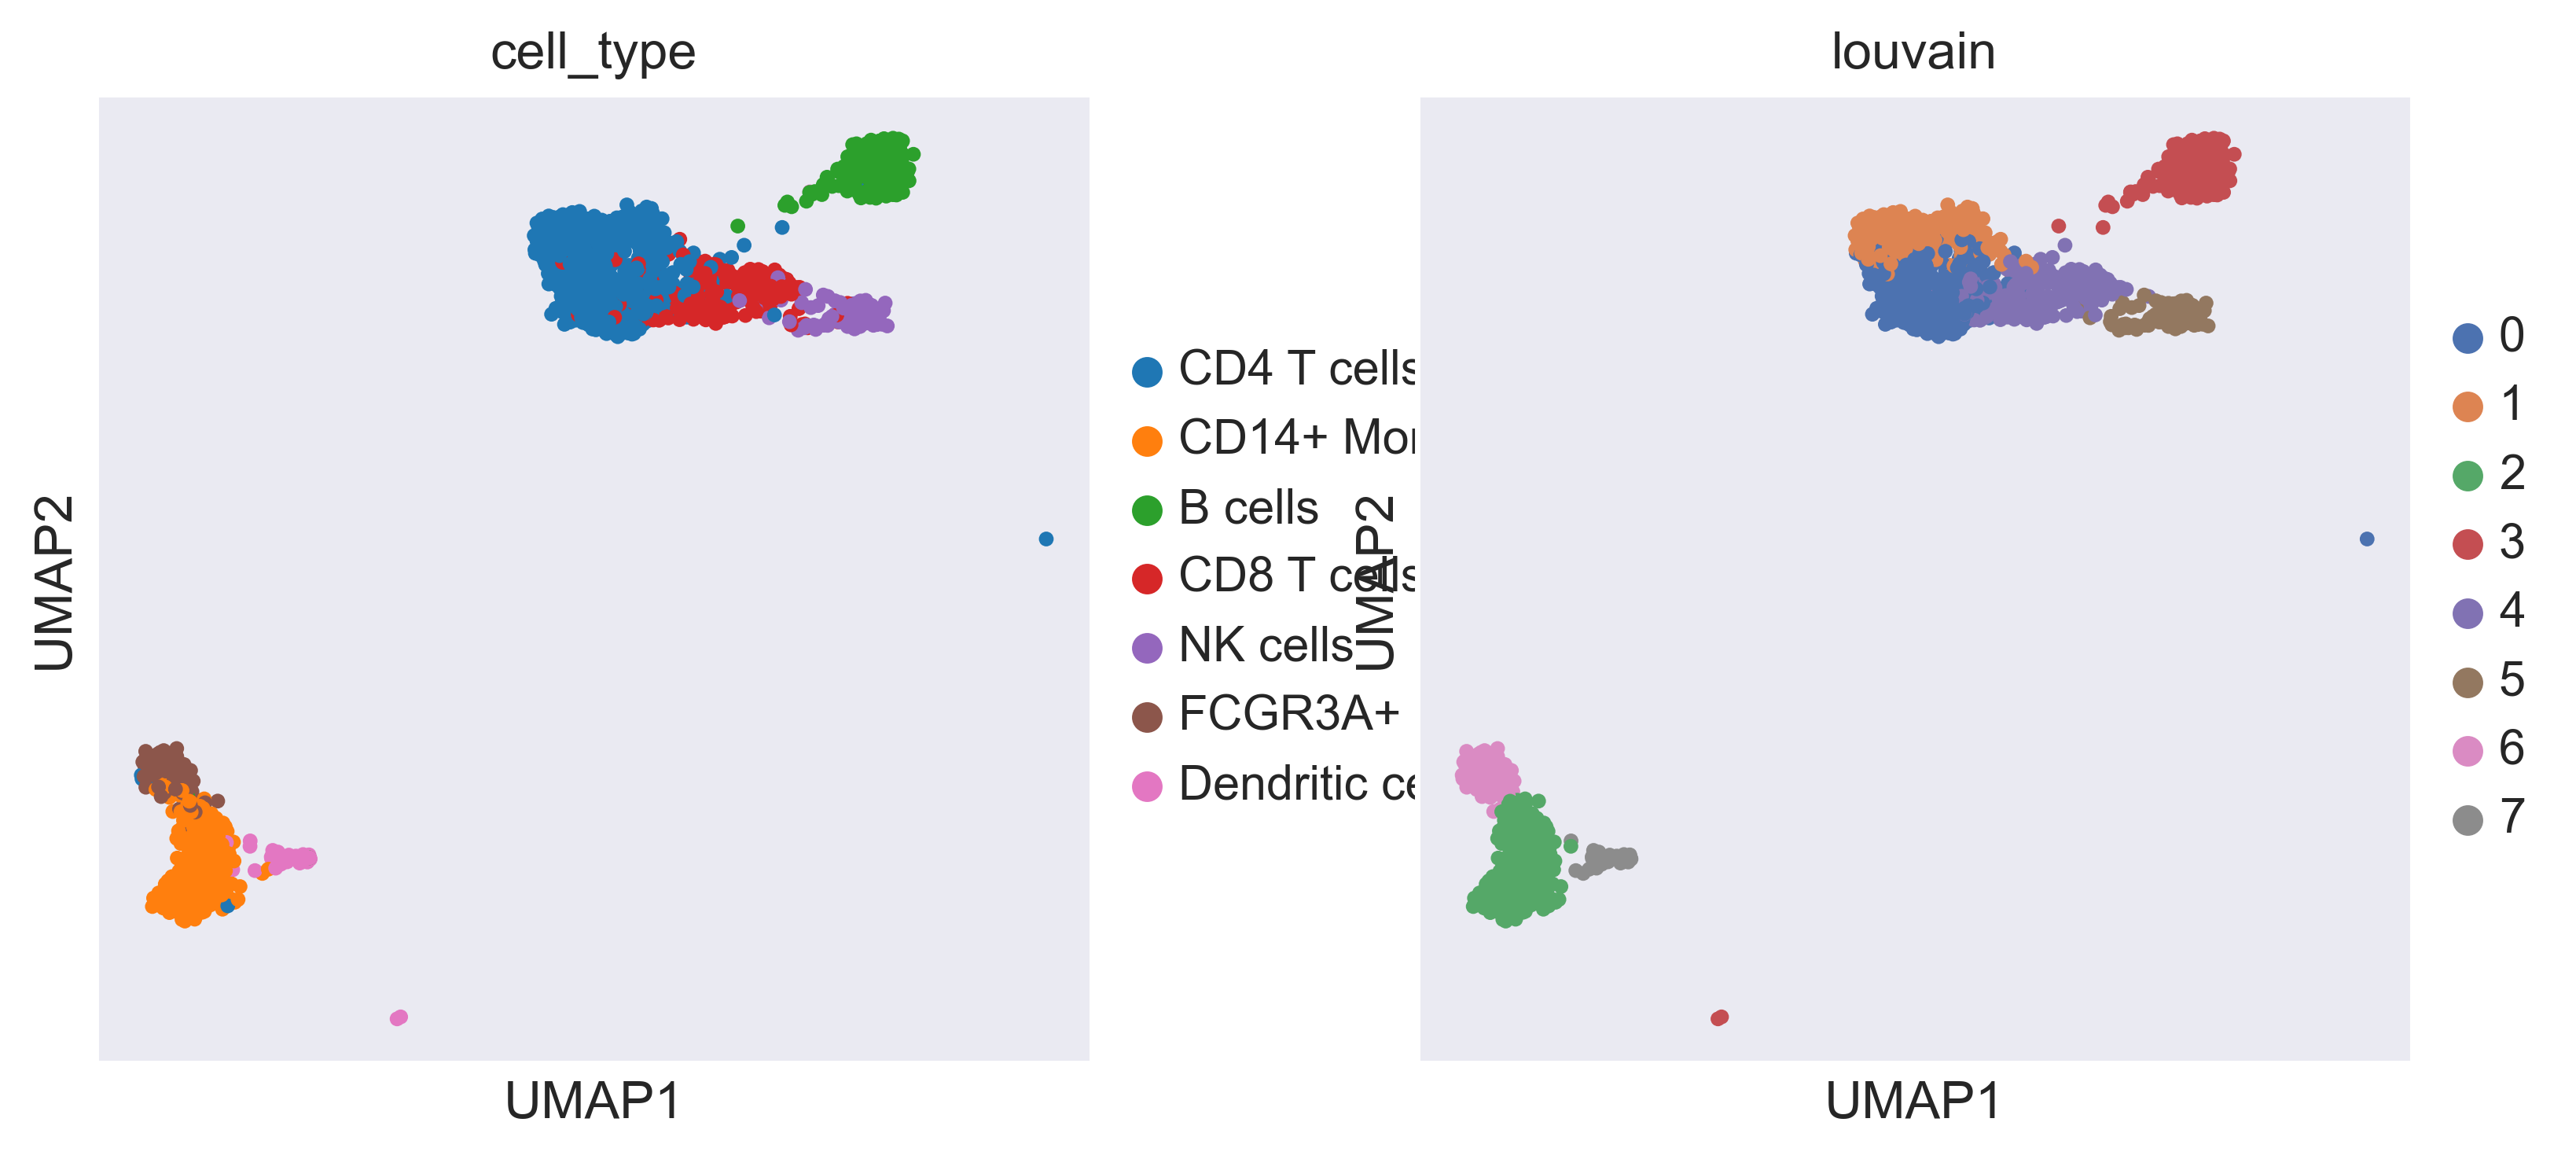

In [53]:
sc.pp.pca(adataz,)
sc.pp.neighbors(adataz,)
sc.tl.louvain(adataz,)
sc.pl.umap(
    adataz,
    ncols=2,
    color=[
        "cell_type",
        "louvain",
    ],
)


In [54]:
## preparing the data
enc_labels = LabelEncoder()
labelsz = enc_labels.fit_transform(adataz.obs["cell_type"],)
labelsz = F.one_hot(torch.tensor(labelsz)).float()
dataz = torch.tensor(adataz.X)
dataz.shape
adataz.obs["label"] = enc_labels.inverse_transform(
    labelsz.argmax(-1).detach().numpy(),
)
adataz.obs["label_num"] = labelsz.argmax(-1).detach().numpy().astype('str')
louvainz = [int(x) for x in adataz.obs["louvain"]]
louvainz = F.one_hot(torch.tensor(louvainz)).float()
conditionsz = enc_conds.fit_transform(adataz.obs["condition"],)
conditionsz = F.one_hot(torch.tensor(conditionsz), num_classes=2,).float()

## Testing the accuracy of louvain clustering
in this case, it is pretty accurate

In [56]:
r,p,s = ut.estimateClusterAccuracy(y=louvainz, labels=labelsz)
print(p,r,s)
r = r[r>=0]
s = s[s>=0]
print("dataz: ",(r*s).sum().item() / s.sum().item(), r.mean().item())
# lists shown below:
#[class assignment], [% of asigned class in the cluster], [# of samples in the cluster], total_accuracy, unweigheted_mean_accuracy

[2. 2. 1. 0. 3. 6. 5. 4.] [0.95967742 0.98174442 0.96280992 0.97982709 0.80712166 0.93548387
 0.88961039 0.90909091] [620. 493. 484. 347. 337. 155. 154.  33.]
dataz:  0.9412886008387342 0.9281707099180236


Since for this dataset Louvain clustering is very good, we will use the louvain clusters as the labels and do
(semi)supervised training of gmvae.
with unsupervised training, it might miss the Dendritic class.

Just for demonstration purpose, we show how to create labeled and unlabeled subset partition.
In this case there is no point of doing unlabeled training we're better off doing supervised learening of the louvain clusters.

In [57]:
labeledSubset = ut.randomSubset(s=len(adataz), r=0.45) #45/55 split between labeled and unlabeled
labeled_loader = torch.utils.data.DataLoader(
        dataset = ut.SynteticDataSet(
            [dataz[labeledSubset],
                louvainz[labeledSubset],
                conditionsz[labeledSubset], # we don't need condition here but its for demo purpose
                ],),
            batch_size=2**11,
            shuffle=True,
            )
unlabeled_loader = torch.utils.data.DataLoader(
        dataset = ut.SynteticDataSet(
            [dataz[~labeledSubset],
                labelsz[~labeledSubset],
                conditionsz[~labeledSubset],
                ],),
            batch_size=2**11,
            shuffle=True,
            )
# and the full dataset loader (no splits)
data_loader = torch.utils.data.DataLoader(
        dataset = ut.SynteticDataSet(
            [ dataz,
                labelsz,
                conditionsz,
                ],),
            batch_size=2**11,
            shuffle=True,
            )

In [65]:
model = mmodels.VAE_Dirichlet_GMM_TypeB1602z(
    nx=adataz.n_vars,
    nz=8,
    nw=8,
    nclasses=louvainz.shape[1],
    concentration=1e0,
    dropout=15e-2,
    bn=True,
    reclosstype="mse",
    restrict_w=True,
    restrict_z=True,
    positive_rec=True,
    #nh=2**11,
    #nhp=2**11,
    #nhq=2**11,
    numhidden=4,
    numhiddenp=4,
    numhiddenq=4,
)
model.apply(ut.init_weights)
print()

In [66]:
# training (unsupervised)
training.basicTrainLoop?

Signature:
training.basicTrainLoop(
    model,
    train_loader: torch.utils.data.dataloader.DataLoader,
    test_loader: Optional[torch.utils.data.dataloader.DataLoader] = None,
    num_epochs: int = 10,
    lrs: Iterable[float] = [0.001],
    device: str = 'cuda:0',
    wt: float = 0.0001,
    loss_type: str = 'total_loss',
    report_interval: int = 3,
    do_plot: bool = False,
    test_accuracy: bool = False,
) -> None
Docstring: non-conditional version of basicTrainLoopCond
File:      ~/my_gits/mg22/gmvae/training/gmvaeTraining.py
Type:      function


In [67]:
training.trainSemiSuperLoop?

Signature:
training.trainSemiSuperLoop(
    model,
    train_loader_labeled: torch.utils.data.dataloader.DataLoader,
    train_loader_unlabeled: torch.utils.data.dataloader.DataLoader,
    test_loader: torch.utils.data.dataloader.DataLoader,
    num_epochs=15,
    lrs: Iterable[float] = [0.001],
    device: str = 'cuda:0',
    wt=0.0001,
    do_unlabeled: bool = True,
    do_validation: bool = True,
    report_interval: int = 3,
    do_plot: bool = False,
    test_accuracy: bool = False,
) -> None
Docstring: non-conditional version of trainSemiSuperLoop
File:      ~/my_gits/mg22/gmvae/training/gmvaeTraining.py
Type:      function


In [68]:
training.trainSemiSuperLoop(
    model,
    labeled_loader,
    unlabeled_loader,
    data_loader,
    num_epochs=50,
    lrs = [
        1e-5,
        1e-4,
        1e-3,
        1e-3,
        1e-3,
        1e-3,
        1e-4,
        1e-5,
    ],
    test_accuracy=False,
    do_unlabeled=True,
    do_validation=False,
    report_interval=0,
    wt=1e-4,
)

epoch's lr =  1e-05
epoch's lr =  0.0001
epoch's lr =  0.001
epoch's lr =  0.001
epoch's lr =  0.001
epoch's lr =  0.001
epoch's lr =  0.0001
epoch's lr =  1e-05
done training


In [69]:
## testing accuracy
r,p,s = ut.estimateClusterImpurity(model, dataz, labelsz, "cuda", )
print(p,r,s)
r = r[r>=0]
s = s[s>=0]
print("acc= \n", (r*s).sum().item() / s.sum().item(), r.mean().item())

[2. 2. 1. 0. 3. 6. 5. 4.] [0.95190713 0.98640777 0.96473029 0.98265896 0.81570997 0.93589744
 0.88461538 0.91176471] [603. 515. 482. 346. 331. 156. 156.  34.]
acc= 
 0.9424323293938238 0.9292114555224495


In [70]:
## testing accuracy
r,p,s = ut.estimateClusterImpurity(model, dataz, louvainz, "cuda", )
print(p,r,s)
r = r[r>=0]
s = s[s>=0]
print("acc= \n", (r*s).sum().item() / s.sum().item(), r.mean().item())

[0. 1. 2. 3. 4. 5. 6. 7.] [0.95356551 0.93203883 1.         1.         0.94864048 0.99358974
 0.98717949 0.97058824] [603. 515. 482. 346. 331. 156. 156.  34.]
acc= 
 0.9679756004574914 0.9732002862753504


## saving model parameters and model state dict
saving the parameters stores the name of the model, the values of its hyperparameters etc. in a json file.
this helps if you have a saved model but you forgot what parameters you used.
in order to load the saved state, you need to first create a new model with the same settings.
Hence always save both the state dict and the model parameters as demonstrated here.

We are suggesting to always include a timestamp or something similar in the name. In case you run your code again, it will not overwrite your
old saved results. It also helps tracking back when the saved model had been made.

In [76]:
# json with model parameters
ut.saveModelParameters(
        model,
        "./results/fake_model_delete_me_later" + str(datetime.timestamp(datetime.now())) + "model_params.json",
        method="json",
        )

# the model state dict (might be somewhat large) 
torch.save(
        model.state_dict(),
        "./results/fake_model_delete_me_later" + str(datetime.timestamp(datetime.now())) + "model_state.pt",
        )

## howto reload a model
construct your model, same settings as you used originally. In the likely event that you forgot the settings,
first load the model parmeter json file as shown below,
then create the model and then load state dict as shown below.

In [77]:
# load the json with to see what parameters to set for your model:
ut.loadModelParameter("results/fake_model_delete_me_later1671712979.895755model_params.json")

{'myName': "<class 'gmvae.models.gmvaeModels.VAE_Dirichlet_GMM_TypeB1602z'>",
 'training': False,
 '_buffers': {},
 '_backward_hooks': {},
 '_is_full_backward_hook': None,
 '_forward_hooks': {},
 '_forward_pre_hooks': {},
 '_state_dict_hooks': {},
 '_load_state_dict_pre_hooks': {},
 '_load_state_dict_post_hooks': {},
 'nx': 7000,
 'nh': 1024,
 'nhq': 1024,
 'nhp': 1024,
 'nz': 8,
 'nw': 8,
 'eps': 1e-09,
 'nclasses': 8,
 'numhidden': 4,
 'numhiddenq': 4,
 'numhiddenp': 4,
 'dscale': 1.0,
 'wscale': 1.0,
 'yscale': 1.0,
 'zscale': 1.0,
 'cc_scale': 10.0,
 'cc_radius': 0.1,
 'mi_scale': 1.0,
 'recloss_mii': 0,
 'concentration': 1.0,
 'relax': False,
 'restrict_w': True,
 'restrict_z': True,
 'softargmax': False,
 'use_resnet': False,
 'reclosstype': 'mse',
 'classify_with_mu': False}

In [78]:
# model = mmodels....... as originally shown above
# then load model's state dict
model.load_state_dict(
    torch.load("results/fake_model_delete_me_later1671712989.584382model_state.pt",))

<All keys matched successfully>

## ploting results
same as we did in the blobs case

In [83]:
# insert latent encoding into the dataframe
output = model(dataz, )
adataz.obsm["mu_z"] = output["mu_z"].detach().numpy()
adataz.obsm["z"] = output["z"].detach().numpy()
adataz.obsm["mu_w"] = output["mu_w"].detach().numpy()
adataz.obsm["w"] = output["w"].detach().numpy()
adataz.obs["predict"] = output["q_y"].argmax(-1).detach().numpy().astype(str)
del output

In [85]:
pca = PCA(n_components=2)
adataz.obs[["pcz1", "pcz2"]] = pca.fit_transform(adataz.obsm["mu_z"])
adataz.obs["predict_int"] = [int(x) for x in adataz.obs["predict"]]

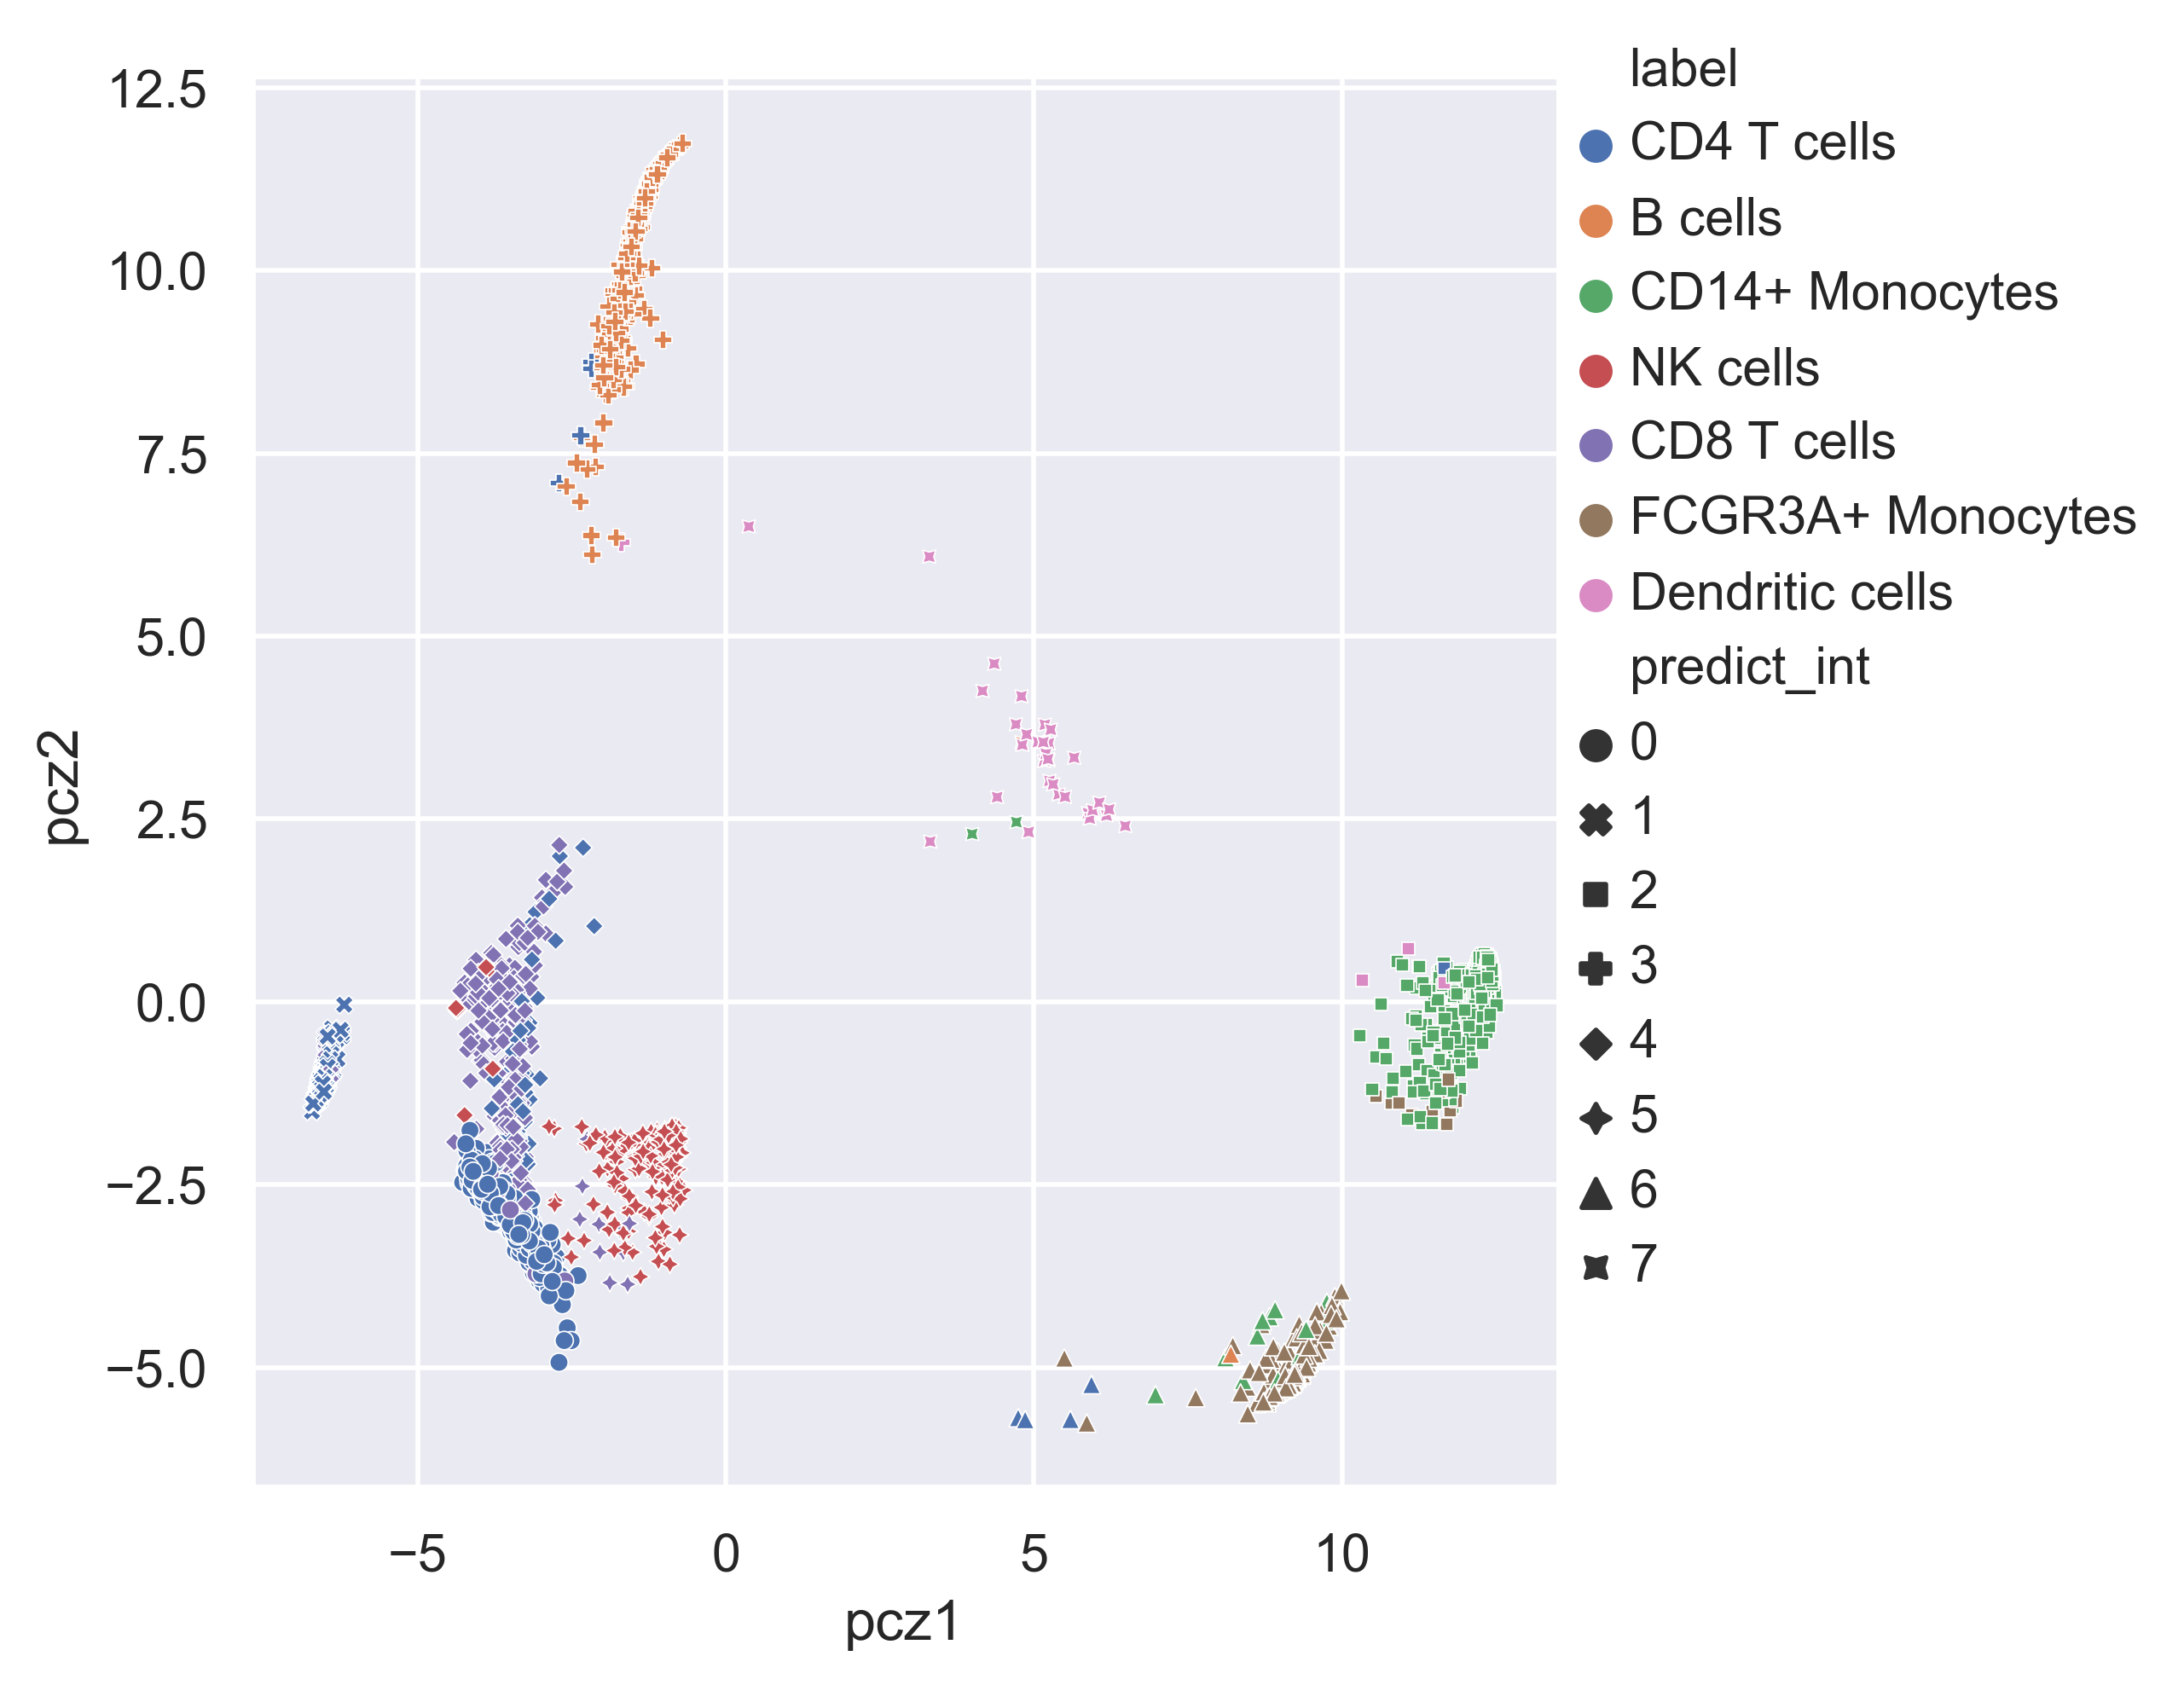

In [87]:
ax=sns.relplot(
    data=adataz.obs,
    x="pcz1",
    y="pcz2",
    hue="label",
    style="predict_int",
    s=1.5e1,
)
sns.move_legend(ax, "upper right",)

/home/ykolb/mambaforge/envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored

/home/ykolb/mambaforge/envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored

/home/ykolb/mambaforge/envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



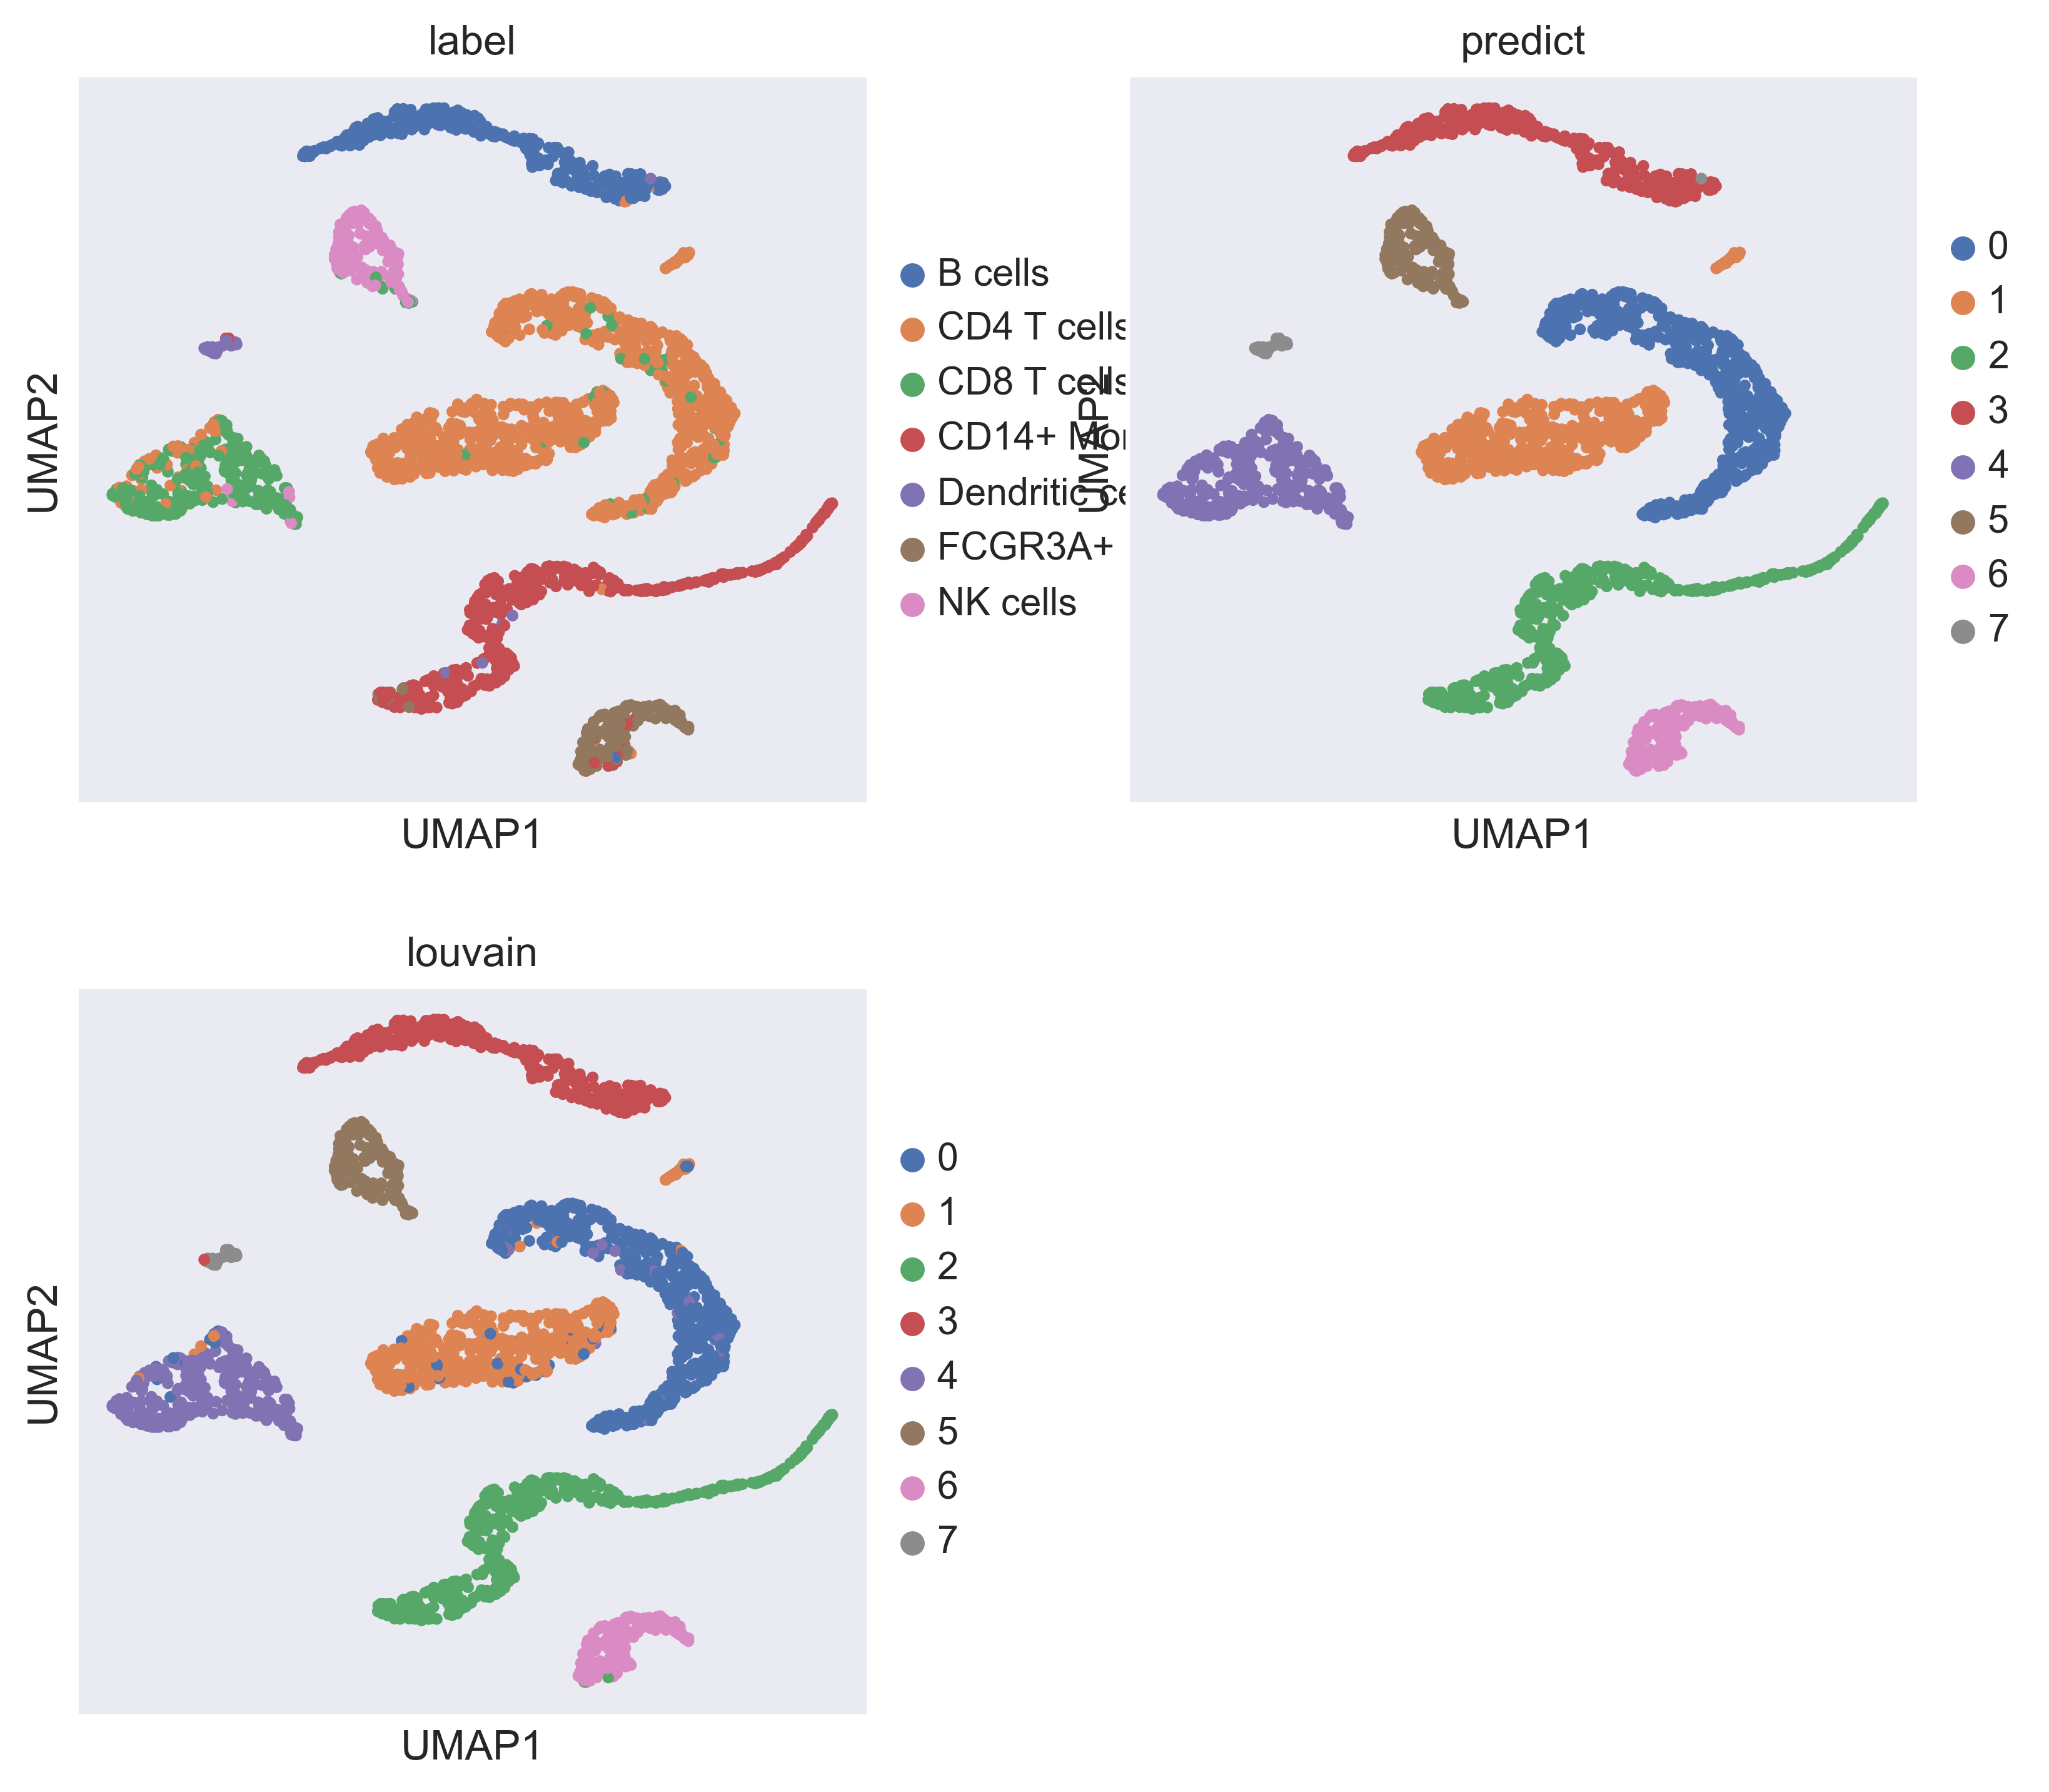

In [89]:
# doing UMAP with scanpy
sc.pp.neighbors(adataz, use_rep="mu_z",)
sc.tl.umap(adataz,)
sc.pl.umap(
    adataz,
    ncols=2,
    color=[
        "label",
        "predict",
        "louvain",
    ],
)